In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install google-play-scraper pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install Sastrawi
!pip install bertopic
!pip install sentence-transformers
!pip install emoji

In [ ]:


# Core Libraries
import re
import time
import warnings
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from datetime import datetime
from tqdm import tqdm

# NLP & Text Processing
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from wordcloud import WordCloud, STOPWORDS


# Topic Modeling & Clustering

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon


# Machine Learning (Classification)
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Scraping
from google_play_scraper import reviews, Sort, app


# Load Data

In [ ]:
# This code sets up basic parameters for scraping Google Play reviews of Shopee Indonesia. It defines the app package, language, country, and limits for how many reviews to collect per rating.

# It then retrieves the latest app metadata using app(), extracts the current version and last update timestamp, converts the timestamp into a readable date, and prints this information.
# The all_reviews list is initialized to store the reviews that will be collected later.

In [ ]:


PACKAGE = "com.shopee.id"
LANG = "id"
COUNTRY = "id"
TARGET_PER_RATING = 8000   # 8K per rating
MIN_REVIEWS_PER_VERSION = 200  # only version with review >=200

all_reviews = []

print("Fetching latest app metadata...")
info = app(PACKAGE, lang=LANG, country=COUNTRY)
latest_version = info.get("version")
latest_update_ts = info.get("updated")
latest_update_date = (
    datetime.fromtimestamp(latest_update_ts).strftime("%Y-%m-%d")
    if latest_update_ts else None
)
print(f"Latest version: {latest_version}")
print(f"Latest update date: {latest_update_date}")



Fetching latest app metadata...
Latest version: 3.62.40
Latest update date: 2025-11-28


In [ ]:
# This loop collects up to 8,000 Google Play reviews for each star rating from 1 to 5.
# For each rating, the code repeatedly calls the reviews() API, using pagination tokens to continue fetching batches of 200 reviews at a time.

# Each review is filtered to ensure it contains an app version. Valid reviews are saved into the all_reviews list along with metadata such as rating, text, likes, review date, and the latest app version info.

# The loop stops once the target number of reviews is reached or when no more pages are available. Finally, all collected reviews are converted into a pandas DataFrame.

In [ ]:
#  SCRAPE 8K REVIEW PER RATING (1–5)

for rating in range(1, 6):
    print(f"\nScraping rating {rating} ...")
    collected = 0
    token = None

    while collected < TARGET_PER_RATING:

        try:
            result, token = reviews(
                PACKAGE,
                lang=LANG,
                country=COUNTRY,
                sort=Sort.NEWEST,
                count=200,
                continuation_token=token,
                filter_score_with=rating
            )
        except Exception as e:
            print(f"Error: {e}. Retrying...")
            time.sleep(2)
            continue

        for r in result:
            review_ver = r.get("reviewCreatedVersion")
            if review_ver is None:
                continue  # skip review tanpa versi

            all_reviews.append({
                "review_text": r.get("content"),
                "rating": r.get("score"),
                "likes": r.get("thumbsUpCount"),
                "review_app_version": review_ver,
                "review_date": r.get("at"),
                "latest_version": latest_version,
                "latest_version_release_date": latest_update_date
            })

            collected += 1
            if collected >= TARGET_PER_RATING:
                break

        if token is None:
            break

print("Scraping done.")
df = pd.DataFrame(all_reviews)


Scraping rating 1 ...

Scraping rating 2 ...

Scraping rating 3 ...

Scraping rating 4 ...

Scraping rating 5 ...
Scraping done.


In [ ]:
# Filter: only accept version if review >= MIN_REVIEWS_PER_VERSION

version_counts = df['review_app_version'].value_counts()
sufficient_versions = version_counts[version_counts >= MIN_REVIEWS_PER_VERSION].index

df_filtered = df[df['review_app_version'].isin(sufficient_versions)].reset_index(drop=True)

print("version that has enough review", list(sufficient_versions))
print("Total review after filter:", len(df_filtered))
df_filtered.head()


version that has enough review ['3.61.28', '3.60.30', '3.59.41', '3.62.40', '3.54.23', '3.62.38', '3.56.29', '3.59.43', '3.57.31', '3.55.29', '3.57.41', '3.53.24', '3.58.33', '3.51.33', '3.45.60', '3.52.19', '3.46.37', '3.43.40', '3.44.26', '3.60.25', '3.47.40', '3.50.24', '3.58.36', '3.51.24', '3.47.39', '3.49.41', '3.49.37', '3.48.28', '3.59.39', '3.48.31', '3.51.21', '3.42.24', '3.59.38', '3.41.45', '3.40.11', '3.59.40', '3.57.29']
Total review after filter: 35867


review_text  rating  likes  \
0  ga bisa belanja Mala disuru verifikasi pasword...       1      0   
1                               tidak bisa di cekout       1      0   
2             habis update koq malah lemot aplksinya       1      0   
3  pengiriman nya tolong diperbaiki spx lambat ba...       1      0   
4   wkwk shopeefoodnya makin lama diskon makin dikit       1      0   

  review_app_version         review_date latest_version  \
0            3.62.40 2025-11-29 14:29:03        3.62.40   
1            3.62.40 2025-11-29 14:22:43        3.62.40   
2            3.62.40 2025-11-29 14:01:40        3.62.40   
3            3.62.40 2025-11-29 14:00:27        3.62.40   
4            3.62.40 2025-11-29 13:58:16        3.62.40   

  latest_version_release_date  
0                  2025-11-28  
1                  2025-11-28  
2                  2025-11-28  
3                  2025-11-28  
4                  2025-11-28

In [ ]:
df_filtered.head()

review_text  rating  likes  \
0  aplikasi macam apa ini tiba tiba-tiba cod nona...       1      0   
1  barangnya stoknya gak redy semua barang yang s...       1      0   
2  kenapa sih shopee di hp andro manapun nge lag ...       1      0   
3                                   iklan gak ngotak       1      0   
4  sistem dibenerin kenapa dahhh? masa mau shopee...       1      0   

  review_app_version         review_date latest_version  \
0            3.62.40 2025-11-28 18:38:28        3.62.40   
1            3.61.28 2025-11-28 18:35:36        3.62.40   
2            3.62.40 2025-11-28 17:45:46        3.62.40   
3            3.62.38 2025-11-28 17:29:24        3.62.40   
4            3.62.40 2025-11-28 17:03:58        3.62.40   

  latest_version_release_date  
0                  2025-11-28  
1                  2025-11-28  
2                  2025-11-28  
3                  2025-11-28  
4                  2025-11-28

In [ ]:
df_filtered.shape

(35830, 7)

# EDA

In [ ]:
# Check unique versions that appear in the reviews
version_counts = df['review_app_version'].value_counts(dropna=True)

print("Number of unique versions appearing:", len(version_counts))
print("\nTop versions (most reviewed):")
print(version_counts.head(10))


Number of unique versions appearing: 350

Top versions (most reviewed):
review_app_version
3.61.28    8337
3.60.30    2321
3.59.41    2318
3.62.40    1757
3.54.23    1629
3.62.38    1608
3.56.29    1206
3.59.43    1196
3.57.31    1193
3.55.29    1081
Name: count, dtype: int64


Number of reviews per version:
3.40.11: 223 review(s)
3.41.45: 273 review(s)
3.42.24: 320 review(s)
3.43.40: 608 review(s)
3.44.26: 503 review(s)
3.45.60: 803 review(s)
3.46.37: 629 review(s)
3.47.39: 400 review(s)
3.47.40: 486 review(s)
3.48.28: 373 review(s)
3.48.31: 340 review(s)
3.49.37: 384 review(s)
3.49.41: 390 review(s)
3.50.24: 448 review(s)
3.51.21: 331 review(s)
3.51.24: 400 review(s)
3.51.33: 819 review(s)
3.52.19: 682 review(s)
3.53.24: 988 review(s)
3.54.23: 1629 review(s)
3.55.29: 1081 review(s)
3.56.29: 1206 review(s)
3.57.29: 203 review(s)
3.57.31: 1193 review(s)
3.57.41: 1011 review(s)
3.58.33: 840 review(s)
3.58.36: 406 review(s)
3.59.38: 283 review(s)
3.59.39: 363 review(s)
3.59.40: 221 review(s)
3.59.41: 2318 review(s)
3.59.43: 1196 review(s)
3.60.25: 494 review(s)
3.60.30: 2321 review(s)
3.61.28: 8337 review(s)
3.62.38: 1608 review(s)
3.62.40: 1757 review(s)


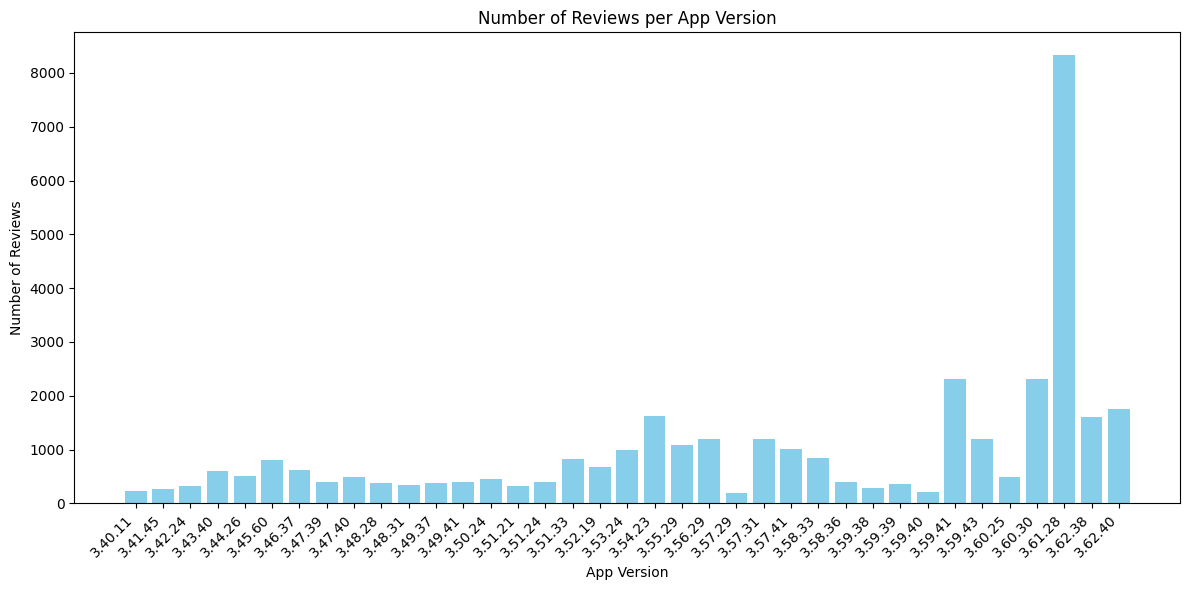

In [ ]:
# Count number of reviews per version
version_counts = df_filtered['review_app_version'].value_counts(dropna=True).sort_index()

print("Number of reviews per version:")
for ver, count in version_counts.items():
    print(f"{ver}: {count} review(s)")

plt.figure(figsize=(12, 6))
plt.bar(version_counts.index, version_counts.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("App Version")
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews per App Version")
plt.tight_layout()
plt.show()


In [ ]:

df_filtered['review_date'] = pd.to_datetime(df_filtered['review_date'])

version_time_range = df_filtered.groupby('review_app_version')['review_date'].agg(['min', 'max']).sort_index()

print("Review date range per version:")
print(version_time_range)


Review date range per version:
                                   min                 max
review_app_version                                        
3.40.11            2025-01-01 12:30:40 2025-11-29 06:51:01
3.41.45            2025-01-07 06:54:22 2025-11-29 09:36:10
3.42.24            2025-01-16 22:53:43 2025-11-29 15:00:29
3.43.40            2025-01-27 17:07:49 2025-11-29 09:08:35
3.44.26            2025-02-26 06:03:11 2025-11-29 02:02:34
3.45.60            2025-03-09 11:54:11 2025-11-29 10:46:35
3.46.37            2025-03-20 12:41:59 2025-11-27 03:05:16
3.47.39            2025-04-03 03:37:04 2025-11-29 13:00:57
3.47.40            2025-04-08 12:12:12 2025-11-29 14:23:02
3.48.28            2025-04-16 12:53:24 2025-11-29 03:14:05
3.48.31            2025-04-23 09:54:22 2025-11-28 02:05:48
3.49.37            2025-05-01 13:19:15 2025-11-28 16:02:55
3.49.41            2025-05-09 12:23:26 2025-11-29 11:25:52
3.50.24            2025-05-15 02:09:55 2025-11-29 10:31:31
3.51.21            2025-0

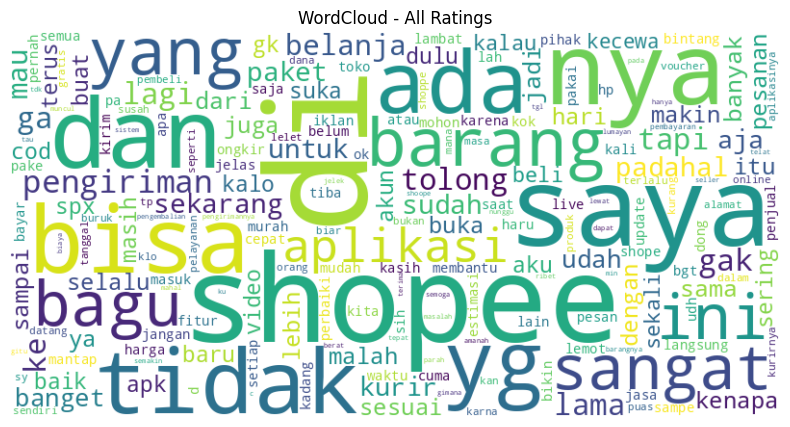

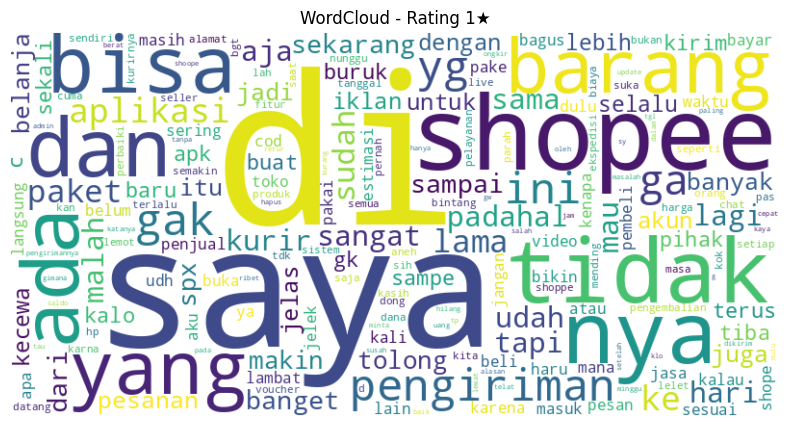

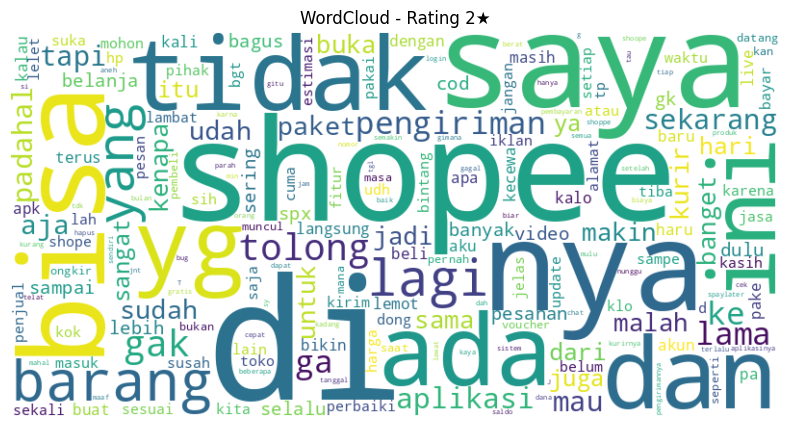

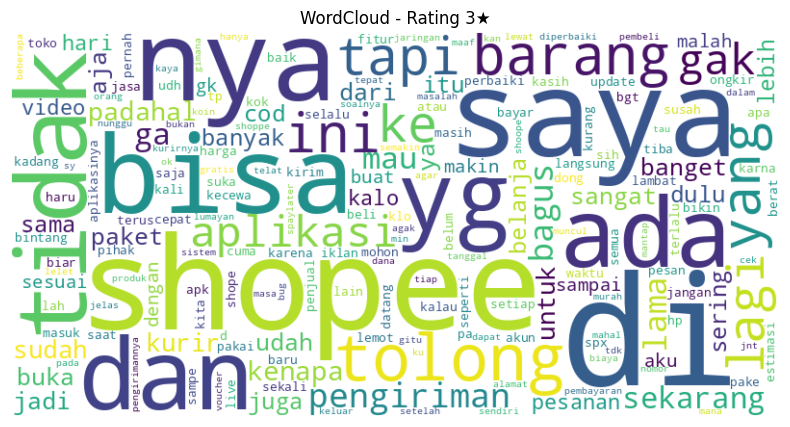

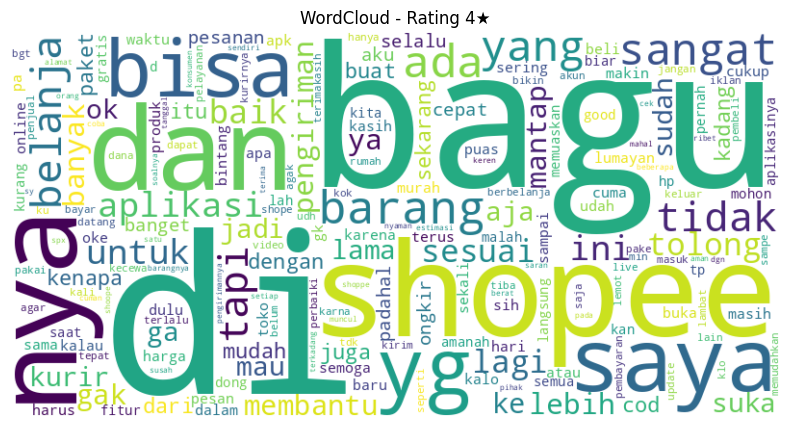

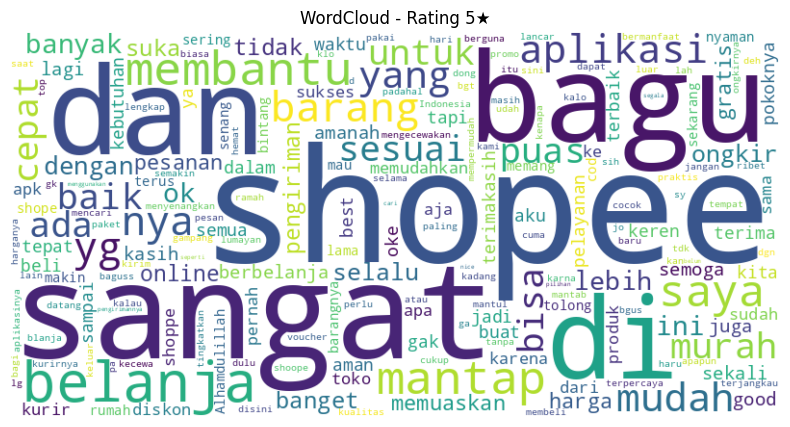

In [ ]:
df_filtered = df_filtered[df_filtered['review_text'].notna()]


def generate_wordcloud(text, title):
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=STOPWORDS,
        collocations=False
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


all_text = " ".join(df_filtered['review_text'])
generate_wordcloud(all_text, "WordCloud - All Ratings")

# WordCloud per rating
for rating in range(1, 6):
    text_rating = " ".join(df_filtered[df_filtered['rating'] == rating]['review_text'])
    generate_wordcloud(text_rating, f"WordCloud - Rating {rating}★")


In [ ]:
import pandas as pd

for r in range(1, 6):
    print(f"\n=== Rating {r} ===")
    sample_reviews = df_filtered[df_filtered['rating'] == r]['review_text'].dropna().sample(5, random_state=42)

    for i, text in enumerate(sample_reviews, start=1):
        print(f"{i}. {text}")



=== Rating 1 ===
1. Setelah di update, spaylater tidak bisa di pakai seperti biasanya.
2. di tolak terus menerus paylater nya
3. boros data, boros memori, kebanyakan notifikasi. pertama buka langsung ke shopee vidio bikin risih + boros paket data. apk buat belanja doang datanya sampe 1Gb lebih, memberatkan sistem. notifikasinya berisik, yg ini gampang ngatasinya dg blokir semua notif
4. proses pengirimanya gak kaya dlu. skarng tambah lama. dari toko jauh pun dulu cepat. kelamakan transit dan sotirnya
5. saya sudah 1 minggu tidak bisa membuka shopee dengan alasan tidak ada koneksi internet padahal semua nya lancar, pembayaran akan telat kalo kaya gini

=== Rating 2 ===
1. gara gara HP ganti mau login lagi susaaahh bangetttt verifikasi wajah gagal gagal terus padahal data sudah valid semua
2. pengiriman tdk sesuai tgl
3. bertahun2 menggunakan shope aman2 saja tidak ada kendala ,tapi sekarang shope sangat mengecewakan dengan adanya paket tiba tiba datang COD dg nominal yg d atas seratusa

In [ ]:
df_filtered

review_text  rating  likes  \
0      topup saldo ga masuk ,,disuruh nunggu 1x24 jam...       1      0   
1      saya pesan berkali kali dibatalkan oleh sistem...       1      0   
2      terlalu banyak iklan spam maksa kali buat di liat       1      0   
3      ga jelas bgt baru dibuka udah ada video , beli...       1      0   
4      ah jdi skrg Shopee payah.. deskripsi nya gabis...       1      0   
...                                                  ...     ...    ...   
35825  sangat memuaskan mudah menemukan barang yang d...       5      0   
35826                                             Mantap       5      0   
35827  selama memakai shopee gak pernah nyesel.kalo b...       5      0   
35828  Terimakasih shopeee sudah mempermudah pembelia...       5      0   
35829  sekarang belanja di shopee lebih mudah pengiri...       5      0   

      review_app_version         review_date latest_version  \
0                3.62.40 2025-11-28 15:13:34        3.62.40   
1                3.62.40 2025-11-28 14:58:58        3.62.40   
2                3.62.40 2025-11-28 14:57:43        3.62.40   
3                3.62.40 2025-11-28 14:50:19        3.62.40   
4                3.61.28 2025-11-28 14:50:16        3.62.40   
...                  ...                 ...            ...   
35825            3.61.28 2025-11-18 23:37:24        3.62.40   
35826            3.59.41 2025-11-18 23:37:07        3.62.40   
35827            3.59.41 2025-11-18 23:34:44        3.62.40   
35828            3.43.40 2025-11-18 23:33:27        3.62.40   
35829            3.61.28 2025-11-18 23:30:07        3.62.40   

      latest_version_release_date  
0                      2025-11-28  
1                      2025-11-28  
2                      2025-11-28  
3                      2025-11-28  
4                      2025-11-28  
...                           ...  
35825                  2025-11-28  
35826                  2025-11-28  
35827                  2025-11-28  
35828                  2025-11-28  
35829                  2025-11-28  

[35830 rows x 7 columns]

## Check Data characteristic

In [ ]:
# This script performs a text noise diagnostic to understand the quality and cleanliness of user-generated review text.
#Several types of noise are checked, including URLs, HTML tags, phone numbers, strange characters, emoji distribution, duplicate text, and character-length statistics.

In [ ]:
# The dataset has a mix of short and very long reviews, providing good textual richness for modeling.
# Only one thing stands out: duplicate reviews (15.8%), which should be removed for indobert.

In [ ]:

df = df_filtered.copy()

def contains_url(text):
    return bool(re.search(r"http\S+|www\.\S+", text))

def contains_html(text):
    return bool(re.search(r"<[^>]+>", text))

def contains_phone(text):
    return bool(re.search(r"\b\d{9,}\b", text))  # 9+ digit number

def contains_weird_char(text):
    return "�" in text

def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

# 1. URL statistics
url_ratio = df['review_text'].apply(contains_url).mean()

# 2. HTML tag statistics
html_ratio = df['review_text'].apply(contains_html).mean()

# 3. Phone number presence
phone_ratio = df['review_text'].apply(contains_phone).mean()

# 4. Weird character presence
weird_ratio = df['review_text'].apply(contains_weird_char).mean()

# 5. Emoji count distribution
all_emojis = df['review_text'].apply(extract_emojis).str.cat()
emoji_counter = Counter(all_emojis)

# 6. Duplicate text ratio
duplicate_ratio = 1 - df['review_text'].nunique() / len(df)

df['text_len'] = df['review_text'].str.len()

length_stats = df['text_len'].describe()

# 8. Characters outside typical range (optional deeper inspection)
all_chars = ''.join(df['review_text'].astype(str).values)
weird_chars = Counter([c for c in all_chars if not (c.isalnum() or c.isspace() or c in ".,!?()[]{}:;/'\"@#%&*-_=+<>")])

print("TEXT NOISE DIAGNOSTIC")

print(f"Contains URL:             {url_ratio*100:.2f}%")
print(f"Contains HTML tags:       {html_ratio*100:.2f}%")
print(f"Contains phone numbers:   {phone_ratio*100:.2f}%")
print(f"Contains weird '�':       {weird_ratio*100:.2f}%")
print(f"Duplicate text ratio:     {duplicate_ratio*100:.2f}%\n")

print("=== TEXT LENGTH STATS ===")
print(length_stats, "\n")

print("=== TOP 20 EMOJIS ===")
print(emoji_counter.most_common(20), "\n")

print("=== Weird characters (non-alnum/punctuation) ===")
print(dict(weird_chars))


TEXT NOISE DIAGNOSTIC
Contains URL:             0.00%
Contains HTML tags:       0.00%
Contains phone numbers:   0.00%
Contains weird '�':       0.00%
Duplicate text ratio:     15.81%

=== TEXT LENGTH STATS ===
count    35867.000000
mean        94.926618
std        105.953845
min          1.000000
25%         19.000000
50%         56.000000
75%        133.000000
max        500.000000
Name: text_len, dtype: float64 

=== TOP 20 EMOJIS ===
[('👍', 1252), ('🙏', 823), ('👎', 705), ('😭', 460), ('🏻', 449), ('😡', 223), ('🥰', 218), ('🤣', 127), ('😁', 119), ('🤦', 109), ('😊', 91), ('⭐', 85), ('🥲', 80), ('😔', 77), ('🤬', 73), ('😍', 70), ('😒', 64), ('😄', 62), ('😤', 61), ('👌', 61)] 

=== Weird characters (non-alnum/punctuation) ===
{'🤨': 14, '👎': 705, '🏻': 449, '🙏': 823, '😊': 91, '🤦': 109, '😀': 27, '😤': 61, '🙄': 42, '🤣': 127, '😡': 223, '😃': 50, '😄': 62, '😓': 17, '🥱': 11, '😴': 6, '😮': 50, '\u200d': 111, '💨': 48, '😭': 460, '🤬': 73, '😌': 34, '🏽': 21, '♂': 23, '️': 197, '😠': 36, '🥲': 80, '\U0001fae9': 6, '🥺

In [ ]:
# Duplicate Reviews Should Be Removed Even if Ratings Differ
# The duplicate check shows many reviews that have identical text, but appear in different app versions and sometimes even with different ratings.

In [ ]:
# Check sample duplicate
dups = df[df.duplicated('review_text', keep=False)].copy()

dups = dups.sort_values('review_text')

pd.set_option('display.max_colwidth', None)
dups.head(20)


review_text  rating  likes review_app_version  \
15790                3 aja dulu       3      0            3.58.33   
19083                3 aja dulu       3      0            3.50.24   
20530                3 aja dulu       3      0            3.46.37   
30205             Alhamdulillah       5      0            3.62.40   
14040             Alhamdulillah       3      0            3.62.40   
14354             Alhamdulillah       3      0            3.61.28   
31180                    Amanah       5      0            3.51.21   
34682                    Amanah       5      0            3.61.28   
13590            Aplikasi jelek       2      0            3.42.24   
1505             Aplikasi jelek       1      0            3.61.28   
18456            Aplikasi jelek       3      0            3.51.21   
31131  Aplikasi sangat membantu       5      0            3.61.28   
13509  Aplikasi sangat membantu       2      0            3.42.24   
26794    Aplikasi terlalu berat       4      0            3.55.29   
22314    Aplikasi terlalu berat       4     16            3.61.28   
20797                     B aja       3      0            3.43.40   
27193                     B aja       4      0            3.43.40   
23688                     B aja       4      0            3.59.41   
35356                     BAGUS       5      0            3.56.29   
24699                     BAGUS       4      0            3.57.31   

              review_date latest_version latest_version_release_date  text_len  
15790 2025-09-27 13:49:42        3.62.40                  2025-11-28        10  
19083 2025-05-18 10:03:39        3.62.40                  2025-11-28        10  
20530 2025-03-26 06:48:53        3.62.40                  2025-11-28        10  
30205 2025-11-27 07:25:04        3.62.40                  2025-11-28        13  
14040 2025-11-28 09:39:50        3.62.40                  2025-11-28        13  
14354 2025-11-18 15:35:16        3.62.40                  2025-11-28        13  
31180 2025-11-26 00:20:21        3.62.40                  2025-11-28         6  
34682 2025-11-21 07:56:42        3.62.40                  2025-11-28         6  
13590 2025-01-23 09:54:30        3.62.40                  2025-11-28        14  
1505  2025-11-18 14:40:52        3.62.40                  2025-11-28        14  
18456 2025-06-12 11:05:24        3.62.40                  2025-11-28        14  
31131 2025-11-26 02:24:44        3.62.40                  2025-11-28        24  
13509 2025-01-28 12:24:06        3.62.40                  2025-11-28        24  
26794 2025-08-08 14:48:45        3.62.40                  2025-11-28        22  
22314 2025-11-07 14:03:12        3.62.40                  2025-11-28        22  
20797 2025-03-17 21:29:52        3.62.40                  2025-11-28         5  
27193 2025-07-31 09:00:20        3.62.40                  2025-11-28         5  
23688 2025-10-13 11:22:09        3.62.40                  2025-11-28         5  
35356 2025-11-20 10:46:26        3.62.40                  2025-11-28         5  
24699 2025-09-25 00:17:16        3.62.40                  2025-11-28         5

In [ ]:
df

review_text  \
0                                                                                                                                                                             oke baik   
1                                                                                                                                                             2 hari ini rusak ini apl   
2                                                                                                                                                  iklan ny mksa bgt buat buka apk ny.   
3      Shopee lelet, saya kecewa dengan Shopee, hapus aja aplikasi ini dari sini, bener bener lelet, padahal wifi drmh lancar jaya, KECEWA SAYA buka produk aja lama banget proses nya   
4                                                                                                                                                             pesanan lama datang nya,   
...                                                                                                                                                                                ...   
35856                                                                                                                                                                  sangat membantu   
35857                                                                                                                                                                            bagus   
35858                                                                                                                                                                 shopee memuaskan   
35859                                                                                                                                                                Banyak vouchernya   
35860                                                                                                                                                                           mantap   

       rating  likes review_app_version         review_date latest_version  \
0           1      0            3.62.40 2025-11-29 11:31:04        3.62.40   
1           1      0            3.62.40 2025-11-29 11:25:16        3.62.40   
2           1      0            3.49.41 2025-11-29 11:19:40        3.62.40   
3           1      0            3.62.40 2025-11-29 11:11:46        3.62.40   
4           1      0            3.61.28 2025-11-29 11:00:48        3.62.40   
...       ...    ...                ...                 ...            ...   
35856       5      0            3.61.28 2025-11-19 13:07:10        3.62.40   
35857       5      0            3.61.28 2025-11-19 13:05:53        3.62.40   
35858       5      0            3.60.30 2025-11-19 13:05:07        3.62.40   
35859       5      0            3.61.28 2025-11-19 13:03:05        3.62.40   
35860       5      0            3.55.29 2025-11-19 13:00:28        3.62.40   

      latest_version_release_date  text_len  
0                      2025-11-28         8  
1                      2025-11-28        24  
2                      2025-11-28        35  
3                      2025-11-28       175  
4                      2025-11-28        24  
...                           ...       ...  
35856                  2025-11-28        15  
35857                  2025-11-28         5  
35858                  2025-11-28        16  
35859                  2025-11-28        17  
35860                  2025-11-28         6  

[35861 rows x 8 columns]

In [ ]:
# text len 1-3 should also be removed because they will become noise for indobert

In [ ]:
df['text_len'] = df['review_text'].str.len()
df['text_len'].describe()


count    35861.000000
mean        94.924765
std        105.937806
min          1.000000
25%         19.000000
50%         56.000000
75%        133.000000
max        500.000000
Name: text_len, dtype: float64

## Train Test Split


In [ ]:
# converts numeric ratings into sentiment labels (negative, neutral, positive) and then splits the dataset into training and testing sets.
# The split uses stratification to preserve the sentiment distribution across both sets.

In [ ]:
# Map rating values to sentiment labels
def rating_to_sentiment(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df['sentiment'] = df['rating'].apply(rating_to_sentiment)


train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']  # preserve sentiment distribution
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


Train size: 28693, Test size: 7174


In [ ]:
# LOWERCASE + REMOVE DUPLICATES
def clean_text(df_subset):
    df_cleaned = df_subset.copy()

    df_cleaned["review_text"] = df_cleaned["review_text"].str.lower()

    df_cleaned = df_cleaned.drop_duplicates(subset="review_text", keep="first")

    df_cleaned = df_cleaned.reset_index(drop=True)

    print("Number of rows before cleaning :", len(df_subset))
    print("Number of rows after cleaning  :", len(df_cleaned))
    print("Number of duplicates removed   :", len(df_subset) - len(df_cleaned))

    return df_cleaned

train_clean = clean_text(train_df)
test_clean = clean_text(test_df)


Number of rows before cleaning : 28693
Number of rows after cleaning  : 24109
Number of duplicates removed   : 4584
Number of rows before cleaning : 7174
Number of rows after cleaning  : 6166
Number of duplicates removed   : 1008


In [ ]:
train_clean['text_len'] = train_clean['review_text'].str.len()
train_clean['text_len'].describe()


count    24109.000000
mean       112.042764
std        108.177208
min          1.000000
25%         34.000000
50%         75.000000
75%        153.000000
max        500.000000
Name: text_len, dtype: float64

In [ ]:
# remove text_len <= 3

In [ ]:
min_len = 3
train_clean = train_clean[train_clean['text_len'] >= min_len].reset_index(drop=True)
print(f"Train size after removing short texts: {len(train_clean)}")


Train size after removing short texts: 24063


In [ ]:
test_clean = test_clean[test_clean['text_len'] >= min_len].reset_index(drop=True)
print(f"Test size after removing short texts: {len(test_clean)}")


Test size after removing short texts: 6152


## Indobert Processing

In [ ]:
# prepares text data for fine-tuning IndoBERT. It loads the IndoBERT tokenizer, converts sentiment labels into numerical IDs, and defines a custom ReviewDataset class.
# The dataset handles tokenization, padding, truncation, and returns input_ids, attention_mask, and label tensors for use in a PyTorch DataLoader.

In [ ]:
# 1. Tokenizer IndoBERT
model_id = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_id)

label_map = {"negative": 0, "neutral": 1, "positive": 2}
train_labels = [label_map[s] for s in train_clean["sentiment"]]
test_labels  = [label_map[s] for s in test_clean["sentiment"]]


class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),  # shape: (max_len,)
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
train_dataset = ReviewDataset(
    train_clean["review_text"].tolist(),
    train_labels,
    tokenizer
)

test_dataset = ReviewDataset(
    test_clean["review_text"].tolist(),
    test_labels,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Train batches: 1504, Test batches: 385


## Training

In [ ]:
# 1. Load IndoBERT model for 3-class classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=3
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()
epochs = 3

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Average Training Loss: {avg_train_loss:.4f}")


## Prediction & Validation

In [ ]:
# evaluates the trained model on the test set. It switches the model to evaluation mode, performs prediction on each batch without gradient computation, and collects the predicted labels.
# The predicted and true labels are converted back to text form ("negative", "neutral", "positive"), then a standard classification report (precision, recall, F1-score) is generated using classification_report.

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting for Classification Report"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


label_map = {0: "negative", 1: "neutral", 2: "positive"}

all_preds_named = [label_map[p] for p in all_preds]
all_labels_named = [label_map[l] for l in all_labels]

report = classification_report(all_labels_named, all_preds_named, digits=4)
print(report)


Predicting for Classification Report: 100%|██████████| 387/387 [00:48<00:00,  7.97it/s]


              precision    recall  f1-score   support

    negative     0.6985    0.8047    0.7478      2703
     neutral     0.3643    0.2910    0.3235      1268
    positive     0.8126    0.7555    0.7830      2221

    accuracy                         0.6818      6192
   macro avg     0.6251    0.6171    0.6181      6192
weighted avg     0.6710    0.6818    0.6736      6192



In [ ]:
# Even though ratings (1–5 stars) seem to reflect sentiment, relying solely on them is risky. Some users give inconsistent ratings, such as:

# Rating 1 but text says the app is good
# Rating 5 but text complains about bugs
# Sarcastic or joking comments
# Accidental wrong rating selection

# Because of these inconsistencies, rating is not a reliable sentiment label. Training a model to detect sentiment from the text ensures:

# The sentiment aligns with what the user actually wrote
# The analysis is more accurate
# It prevents misleading clusters or topic trends caused by mislabeled data
# It enables detection of hidden frustration inside high ratings

# Therefore, building a sentiment classifier is essential for high-quality text analysis instead of depending solely on user ratings.

In [ ]:

df_results = pd.DataFrame({
    "review_text": test_clean["review_text"].values,
    "rating": test_clean["rating"].values,
    "true_label": all_labels_named,
    "pred_label": all_preds_named
})


df_wrong = df_results[df_results["true_label"] != df_results["pred_label"]]

print(df_wrong.head(10))

                                                                                                                                                                                                                                              review_text  \
6                                                                                                                                                                                                              akhir2 ini kalau payment kok sering mendal   
7                                   sekarang tu estiminasinya tiba-tiba berubah gk sesuai sama tanggal sebelumnya,kadang di majuin kadang di mundurin paket aku jgk gk datang sampe sekarang katanya dari tgl 15-16 tpi sampe sekarang paketnya blm gerak   
10                                                                                                                                                                                                                                               

In [ ]:
# Concatenate train and test because the next step is full-dataset sentiment inference

In [ ]:
df_full_clean = pd.concat([train_clean, test_clean]).reset_index(drop=True)
print("Jumlah data full:", len(df_full_clean))



Jumlah data full: 30213


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

sentiments_full = []

for idx in tqdm(range(len(df_full_clean)), desc="Predicting full dataset"):
    text = df_full_clean.loc[idx, "review_text"]
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
        label = ["negative", "neutral", "positive"][probs.argmax()]
        sentiments_full.append(label)

df_full_clean["sentiment_pred"] = sentiments_full

print("Prediksi sentimen selesai!")
df_full_clean.head()

Predicting full dataset: 100%|██████████| 30213/30213 [04:37<00:00, 108.87it/s]


Prediksi sentimen selesai!


review_text  \
0                                                                                                                                                                                     lelet   
1  sayang sedang tidak suka dengan shopee, sangat buruk, karna sekarang pengiriman cod bosa sampai 5 hari , sedangkan harusnya kan estimasi paling lambat 3 hari, bukan 2 hari, kacau kacau   
2                                                                                                                                                                              sangat bagus   
3                                                                                                                                                                                       . .   
4                                                                                                                                              barang ada yang tidak sesuai yang diklankan😭   

   rating  likes review_app_version         review_date latest_version  \
0       3      0            3.43.40 2025-03-15 22:27:15        3.62.40   
1       1      0            3.60.30 2025-10-27 23:50:30        3.62.40   
2       5      0            3.61.28 2025-11-24 03:50:44        3.62.40   
3       4      0            3.59.41 2025-10-13 06:10:27        3.62.40   
4       2      0            3.56.29 2025-09-22 02:48:38        3.62.40   

  latest_version_release_date  text_len sentiment sentiment_pred  
0                  2025-11-28         5   neutral       negative  
1                  2025-11-28       184  negative       negative  
2                  2025-11-28        12  positive       positive  
3                  2025-11-28         3  positive       positive  
4                  2025-11-28        44  negative        neutral

In [ ]:
df_full_clean.head(20)

review_text  \
0                                                                                                                                                                                                                                                                                                                         lelet   
1                                                                                                                                      sayang sedang tidak suka dengan shopee, sangat buruk, karna sekarang pengiriman cod bosa sampai 5 hari , sedangkan harusnya kan estimasi paling lambat 3 hari, bukan 2 hari, kacau kacau   
2                                                                                                                                                                                                                                                                                                                  sangat bagus   
3                                                                                                                                                                                                                                                                                                                           . .   
4                                                                                                                                                                                                                                                                                  barang ada yang tidak sesuai yang diklankan😭   
5                                                                                                                                                                                                       susah banget login diakun kita sendiri dari bulan kmren coba login dan daftar akun saya yg lama tapi tetep gabisa anehh   
6   gatau kenapa skrg shopee bener bener jelek jasa pengirimannya,waktu sama jnt bagus tuh,cepet pengirimannya.dulu ktnya bakal berkembang,berkembang apanya?setiap hari diliat estimasi tibanya mundur terus,mau sampai kapan shopee begini? aku skrg jadi males mesen dishopee gara gara jasa pengirimannya yang sangat jelek   
7                                                                                                                                                                                                                                                                                            banyak bgt iklan lu, ganggu banget   
8                                                                                                                                                                                                                                                                                                 shoppe nikin mudah berbelanja   
9                                                                                                                                                                                                                                                   sfood lagi parah sy nunggu 1 jam lebih buat dpt driver, tidak ada kejelasan   
10                                                                                                                                                                                                                                                      kenapa sekarang peta saat pengiriman tidak muncul,mohon di update lagi.   
11                                                                                                                                                          setelah sekian lama saya pakai shoope baru kali ini mengalami ada bug,buka pengaturan dan keranjang langsung ngelag blank hitam,layar ga bisa di sentuh sama sekali   
12                                                                                                           

In [ ]:
df_full_clean.to_csv("/content/drive/My Drive/Colab Notebooks/textmining/full_dataset.csv")

## Analysis

In [ ]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/textmining/full_dataset.csv")

In [ ]:
data.head()

Unnamed: 0                                        review_text  rating  \
0           0                                              lelet       3   
1           1  sayang sedang tidak suka dengan shopee, sangat...       1   
2           2                                       sangat bagus       5   
3           3                                                . .       4   
4           4       barang ada yang tidak sesuai yang diklankan😭       2   

   likes review_app_version          review_date latest_version  \
0      0            3.43.40  2025-03-15 22:27:15        3.62.40   
1      0            3.60.30  2025-10-27 23:50:30        3.62.40   
2      0            3.61.28  2025-11-24 03:50:44        3.62.40   
3      0            3.59.41  2025-10-13 06:10:27        3.62.40   
4      0            3.56.29  2025-09-22 02:48:38        3.62.40   

  latest_version_release_date  text_len sentiment sentiment_pred  
0                  2025-11-28         5   neutral       negative  
1                  2025-11-28       184  negative       negative  
2                  2025-11-28        12  positive       positive  
3                  2025-11-28         3  positive       positive  
4                  2025-11-28        44  negative        neutral

In [ ]:
# Convert version string into sortable numeric format
data['version_float'] = data['review_app_version'].str.split('.').apply(
    lambda x: float(".".join(x[:2]))
)

def count_sentiment_by_version(df, label_col):
    counts = df.groupby(['review_app_version', label_col]).size().unstack(fill_value=0)

    counts = counts.reindex(
        sorted(counts.index, key=lambda x: [int(i) for i in x.split('.')])
    )

    counts['total'] = counts.sum(axis=1)
    return counts




In [ ]:
# The proxy sentiment—generated using rating values (1–2 = negative)—shows that almost all early versions (e.g., 3.40.x to 3.45.x) have extremely high negative proportions, often 70–90% negative.
# This is expected because users tend to give low ratings when they are frustrated, and the proxy definition directly maps ratings to negative labels.

In [ ]:
# The model-based predicted sentiment has:

# More positives in nearly all versions.
# Smoother distribution across versions.
# Less extreme skew toward negative sentiment.
# This suggests that many 1–2 star reviews may still contain mixed or positive wording, which the model captures but the rating-based proxy cannot.

# Example:
# Version 3.53.24

# Proxy: 282 neg / 285 neu / 264 pos
# Pred: 380 neg / 213 neu / 238 pos
# The proxy and prediction differ, but both show this version has more balanced sentiment than older versions.

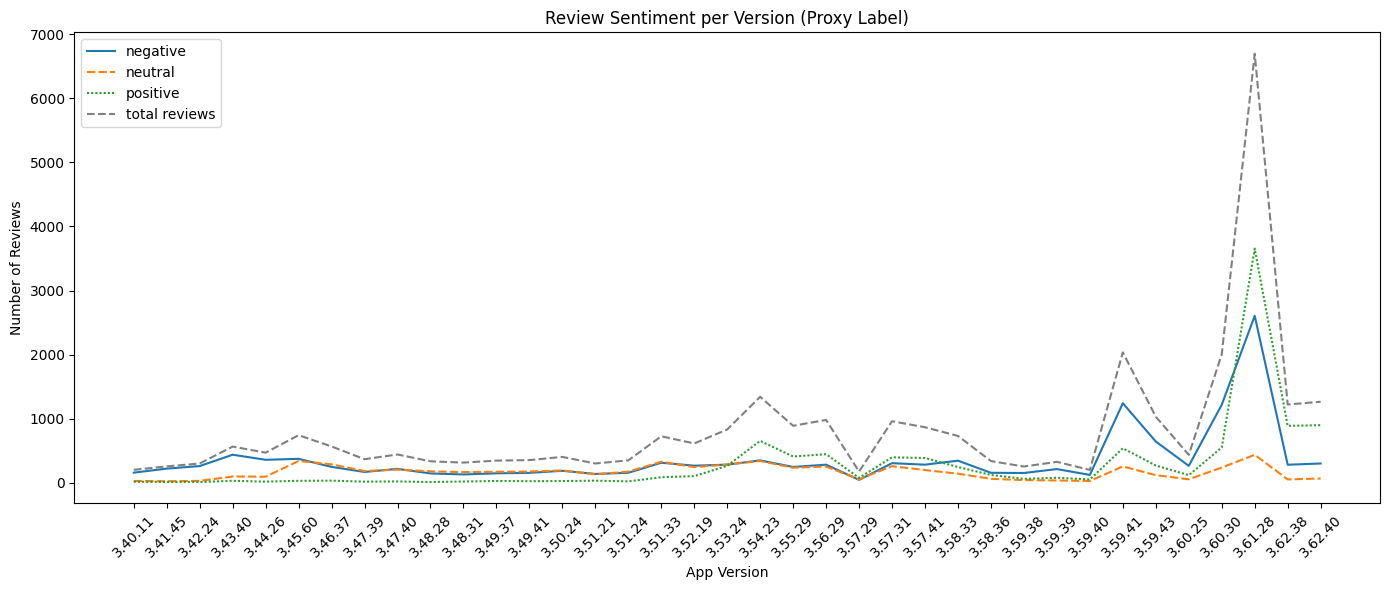

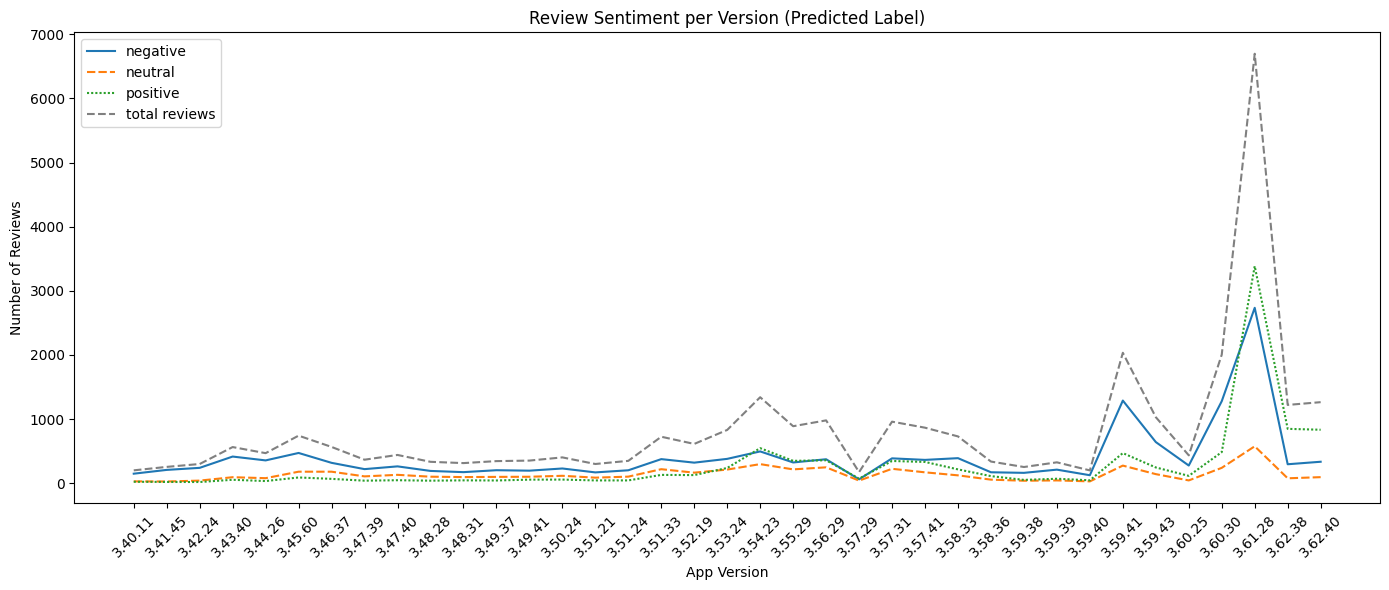

In [ ]:
# 1. Proxy label sentiment (based on rating)
proxy_counts = count_sentiment_by_version(data, 'sentiment')

plt.figure(figsize=(14,6))
sns.lineplot(data=proxy_counts[['negative', 'neutral', 'positive']])
plt.plot(proxy_counts['total'], linestyle='--', color='grey', label='total reviews')
plt.title("Review Sentiment per Version (Proxy Label)")
plt.xlabel("App Version")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# 2. Predicted sentiment label (model output)
pred_counts = count_sentiment_by_version(data, 'sentiment_pred')

plt.figure(figsize=(14,6))
sns.lineplot(data=pred_counts[['negative', 'neutral', 'positive']])
plt.plot(pred_counts['total'], linestyle='--', color='grey', label='total reviews')
plt.title("Review Sentiment per Version (Predicted Label)")
plt.xlabel("App Version")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def print_sentiment_distribution(df, label_col, label_name):
    print(f"\nDistribution {label_name}")
    versions = sorted(df['review_app_version'].unique(), key=lambda x: [int(i) for i in x.split('.')])
    for v in versions:
        subset = df[df['review_app_version'] == v]
        total = len(subset)
        neg = (subset[label_col]=='negative').sum()
        neu = (subset[label_col]=='neutral').sum()
        pos = (subset[label_col]=='positive').sum()
        print(f"{v}: total={total}, negative={neg}, neutral={neu}, positive={pos}")

print_sentiment_distribution(data, 'sentiment', 'Proxy Label')
print_sentiment_distribution(data, 'sentiment_pred', 'Pred Label')



Distribution Proxy Label
3.40.11: total=201, negative=157, neutral=28, positive=16
3.41.45: total=255, negative=220, neutral=23, positive=12
3.42.24: total=300, negative=260, neutral=29, positive=11
3.43.40: total=564, negative=437, neutral=97, positive=30
3.44.26: total=469, negative=358, neutral=94, positive=17
3.45.60: total=742, negative=373, neutral=339, positive=30
3.46.37: total=566, negative=247, neutral=287, positive=32
3.47.39: total=367, negative=168, neutral=182, positive=17
3.47.40: total=441, negative=216, neutral=205, positive=20
3.48.28: total=334, negative=145, neutral=178, positive=11
3.48.31: total=314, negative=129, neutral=166, positive=19
3.49.37: total=345, negative=147, neutral=171, positive=27
3.49.41: total=353, negative=154, neutral=175, positive=24
3.50.24: total=403, negative=186, neutral=191, positive=26
3.51.21: total=300, negative=137, neutral=131, positive=32
3.51.24: total=349, negative=155, neutral=173, positive=21
3.51.33: total=725, negative=312, n

## 3.59.41 Version

In [ ]:

# Stopword list creation
# Loads the default Indonesian stopwords from Sastrawi, then adds a custom list of informal and common conversational words (e.g., “gk”, “aja”, “banget”, “dong”). The final stopword set is a union of both lists.

# remove_stopwords(text)
# Splits text into tokens and removes any word found in the stopword list.

# clean_text(text)
# A full cleaning pipeline:
# Converts text to lowercase.
# Reduces long repeated characters (e.g., “heelloooo” → “helo”).
# Removes URLs, mentions, hashtags, and numbers.
# Removes all non-alphabetic characters.
# Removes stopwords using the function above.
# Removes extra whitespace.
# Removes very short tokens (length ≤ 2).


In [ ]:
factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())

# Additional custom stopwords
custom_stopwords = {
    'nya','yg','gk','ga','gw','lu','aja','kok','sih','banget',
    'anjing','babi','loh','ya','oh','udah','dah','tp','tpi','tdk',
    'pak','kak','kalo','pas','pun','di','ke','dan','dengan','untuk',
    'nih','dong','oke','ok'
}
stopwords = stopwords.union(custom_stopwords)

def remove_stopwords(text):
    tokens = text.split()
    return " ".join(t for t in tokens if t not in stopwords)

def clean_text(text):
    text = text.lower()

    # Reduce repeated characters → "heelloooo" -> "helo"
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Remove URLs, mentions, hashtags, numbers
    text = re.sub(r'http\S+|www\S+|@\S+|#\S+|\d+', ' ', text)

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', ' ', text)


    text = remove_stopwords(text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    text = " ".join([w for w in text.split() if len(w) > 2])

    return text


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# This function performs topic analysis for a specific app version and sentiment.

# Filter reviews by version and predicted sentiment (e.g., negative only).
# Clean text using the custom preprocessing pipeline.
# Embed text using IndoBERT SentenceTransformer.
# Run BERTopic with fixed-seed UMAP + HDBSCAN for reproducible clustering.
# Extract top topics, show wordclouds, and print representative reviews.
# Return the BERTopic model, topic info, and selected top topics.

In [62]:
def analyze_app_version(data, version, top_k=5, seed=42, sentimen="negative"):
    print(f"\n========== Analisis Versi {version} ==========\n")

    # Filter data
    df_neg = data[
        (data["review_app_version"] == version) &
        (data["sentiment_pred"] == sentimen)
    ]

    if df_neg.empty:
        print("Data kosong untuk versi ini.")
        return None, None, None

    texts = df_neg["review_text"].tolist()
    texts_clean = [clean_text(t) for t in texts]

    # Embedding model IndoBERT
    embedding_model = SentenceTransformer("indobenchmark/indobert-base-p1")

    # FIXED RANDOM SEED untuk UMAP dan HDBSCAN
    from umap import UMAP
    import hdbscan

    umap_model = UMAP(
        n_neighbors=15,
        n_components=5,
        min_dist=0.0,
        random_state=seed
    )

    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=15,
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=True
    )

    # BERTopic  seed fix
    topic_model = BERTopic(
        embedding_model=embedding_model,
        language="indonesian",
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        calculate_probabilities=True,
        verbose=False
    )

    topics, probs = topic_model.fit_transform(texts_clean)

    topic_info = topic_model.get_topic_info()

    # Top-k topic (exclude -1)
    top_topics = topic_info[topic_info["Topic"] != -1].head(top_k)
    print(top_topics)

    # WordCloud
    for topic_num in top_topics["Topic"]:
        words = topic_model.get_topic(topic_num)
        if words:
            word_freq = {w: wt for w, wt in words}
            wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

            plt.figure(figsize=(8,4))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Topic {topic_num}")
            plt.show()

    # Representative reviews
    for topic_num in top_topics["Topic"]:
        print(f"\n--- Topic {topic_num} (Representative Reviews) ---")
        reps = topic_model.get_representative_docs(topic_num)
        for i, doc in enumerate(reps[:5]):
            print(f"{i+1}. {doc}\n")

    return topic_model, topic_info, top_topics


In [ ]:
# Topic 0 – Delivery Issues & Potential Fraud (1,029 reviews)
# Main keywords: shopee, barang, pengiriman, kurir, fraud, COD
# Summary:
# Users report serious delivery problems, such as items not arriving, wrong status updates, and suspicious COD behavior. Many complaints involve missing packages, unclear couriers, or tracking inconsistencies. Concerns about fraud appear repeatedly.

# Topic 1 – Too Many Ads / Distracting UI (159 reviews)
# Main keywords: ads, many, disturb, bug, slow
# Summary:
# Users feel the app is filled with intrusive ads that interrupt the experience. Ads are considered annoying and reduce the overall usability of the app.

# Topic 2 – Order Function Not Reliable (23 reviews)
# Main keywords: order, cannot, unreliable
# Summary:
# Short complaints about the ordering feature not working properly, such as being unable to place orders or failed order attempts.

In [ ]:
# Overall Insight

# The main driver of negative sentiment in version 3.59.41 is delivery-related issues and suspicion of fraud, accounting for over 1,000 negative reviews.
# Ads becoming more intrusive is the second major pain point.
# A small portion of users experience order feature failures.


========== Analisis Versi 3.59.41 ==========

   Topic  Count                            Name  \
1      0   1029  0_shopee_barang_gak_pengiriman   
2      1    159  1_iklan_banyak_pengiriman_lama   
3      2     23        2_pesan_gak_alamak_febri   

                                      Representation  \
1  [shopee, barang, gak, pengiriman, aplikasi, la...   
2  [iklan, banyak, pengiriman, lama, ganggu, bug,...   
3  [pesan, gak, alamak, febri, sip, zip, jlek, kw...   

                                 Representative_Docs  
1  [padahal langgan bngt beli shopee shopee sekar...  
2  [iklan ganggu, jelek banyak iklan, banyak ikla...  
3                 [pesan, gak diandalkan, gak pesan]  


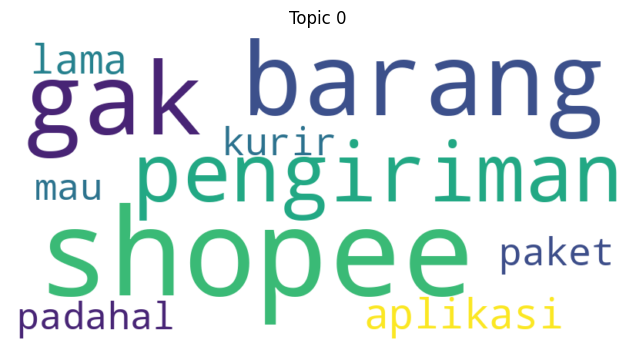

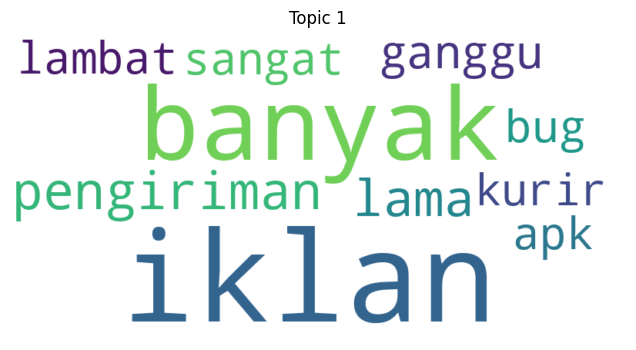

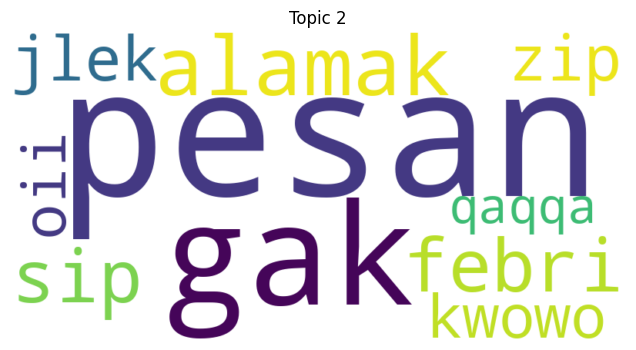


--- Topic 0 (Representative Reviews) ---
1. padahal langgan bngt beli shopee shopee sekarang banyak penipuan barang cod padahal pesan datang rumah nerima lansia mana ngerti resi pengirimannya menggunakan shopee kecewa bngt aman fix sistem shopee perbaiki mulai kurir atur pengiriman shopee kurir punya identitas ciri kurir resmi

2. barang mahal besar papan kayu fjl hilang status shopee terima bukti foto kurir barang tersebut terima status update perjalanan barang mencurigakan notifikasi shopee barang diterima biasanya menghubungi shopee kali tetap shopee mau membantu sama sekali shopee bertanggungjawab banyak beralasan lawak gak belanja shopee goodbye maling

3. pengiriman gak sesuai tanggal barang gak dikirim giliran kurir tanya paketnya gak sama padahal jelas nama kurir gak mau beli sini


--- Topic 1 (Representative Reviews) ---
1. iklan ganggu

2. jelek banyak iklan

3. banyak iklan ganggu


--- Topic 2 (Representative Reviews) ---
1. pesan

2. gak diandalkan

3. gak pesan



(<bertopic._bertopic.BERTopic at 0x78744a9a6780>,
    Topic  Count                            Name  \
 0     -1     78    -1_shopee_barang_iklan_kasih   
 1      0   1029  0_shopee_barang_gak_pengiriman   
 2      1    159  1_iklan_banyak_pengiriman_lama   
 3      2     23        2_pesan_gak_alamak_febri   
 
                                       Representation  \
 0  [shopee, barang, iklan, kasih, penipu, sesuai,...   
 1  [shopee, barang, gak, pengiriman, aplikasi, la...   
 2  [iklan, banyak, pengiriman, lama, ganggu, bug,...   
 3  [pesan, gak, alamak, febri, sip, zip, jlek, kw...   
 
                                  Representative_Docs  
 0  [shopee anjng pesanan pesanan ngga sesuai ngga...  
 1  [padahal langgan bngt beli shopee shopee sekar...  
 2  [iklan ganggu, jelek banyak iklan, banyak ikla...  
 3                 [pesan, gak diandalkan, gak pesan]  ,
    Topic  Count                            Name  \
 1      0   1029  0_shopee_barang_gak_pengiriman   
 2      1    159

In [63]:
analyze_app_version(data, version="3.59.41")



========== Analisis Versi 3.59.41 ==========

   Topic  Count                           Name  \
0      0    419  0_shopee_bagus_belanja_barang   
1      1     51   1_percaya_membantu_buy_baaik   

                                      Representation  \
0  [shopee, bagus, belanja, barang, sangat, sesua...   
1  [percaya, membantu, buy, baaik, bagu, berkas, ...   

                                 Representative_Docs  
0  [sangat bagus membantu, barang bagus sesuai pe...  
1               [apus data berkas, percaya, percaya]  


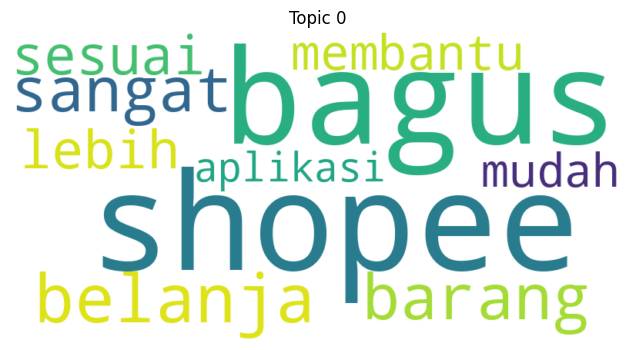

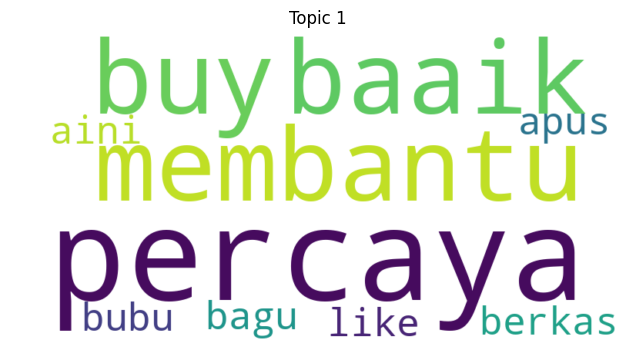


--- Topic 0 (Representative Reviews) ---
1. sangat bagus membantu

2. barang bagus sesuai pesanan

3. suka belanja shopee pengiriman cepat barangnya bagus terus murah semenjak shopee semua kebutuhan jadi mudah belanja shopee


--- Topic 1 (Representative Reviews) ---
1. apus data berkas

2. percaya

3. percaya



(<bertopic._bertopic.BERTopic at 0x7874094f9f40>,
    Topic  Count                           Name  \
 0      0    419  0_shopee_bagus_belanja_barang   
 1      1     51   1_percaya_membantu_buy_baaik   
 
                                       Representation  \
 0  [shopee, bagus, belanja, barang, sangat, sesua...   
 1  [percaya, membantu, buy, baaik, bagu, berkas, ...   
 
                                  Representative_Docs  
 0  [sangat bagus membantu, barang bagus sesuai pe...  
 1               [apus data berkas, percaya, percaya]  ,
    Topic  Count                           Name  \
 0      0    419  0_shopee_bagus_belanja_barang   
 1      1     51   1_percaya_membantu_buy_baaik   
 
                                       Representation  \
 0  [shopee, bagus, belanja, barang, sangat, sesua...   
 1  [percaya, membantu, buy, baaik, bagu, berkas, ...   
 
                                  Representative_Docs  
 0  [sangat bagus membantu, barang bagus sesuai pe...  
 1           

In [64]:
analyze_app_version(data, version="3.59.41", sentimen='positive')


## 3.61.28 Version

In [ ]:
# Topic 0 – Extremely Slow Delivery / Missed Estimates (2,035 reviews)
# Main keywords: shopee, barang, paket, pengiriman, lambat
# Summary:
# The majority of complaints mention very slow deliveries, delays far beyond the estimated time, and inconsistent courier behavior. Many users express deep frustration with late packages and unreliable delivery schedules.

# Topic 1 – Too Many Ads & Laggy App (174 reviews)
# Main keywords: ads, many, slow, app
# Summary:
# Users complain that the app shows too many advertisements, causing the interface to feel cluttered and slow. Ads are considered annoying and negatively affect user experience.

# Topic 2 – Extremely Slow Shipping (General) (71 reviews)
# Main keywords: slow, shipping, very slow
# Summary:
# Short comments emphasizing very slow delivery, often repeated multiple times, showing broad user frustration with shipping performance.

# Topic 3 – Delivery Slow But “Still Within Estimation” (60 reviews)
# Main keywords: slow, estimation
# Summary:
# Users acknowledge that delivery is technically within the estimated timeframe, but still feel it is too slow. The issue is less about failure and more about dissatisfaction with long estimates.

# Topic 4 – SPX (Shopee Express) Slow Delivery (34 reviews)
# Main keywords: spx, slow, lelet
# Summary:
# Complaints specifically target Shopee Express (SPX), describing it as slow or inefficient compared to other couriers.


========== Analisis Versi 3.61.28 ==========

   Topic  Count                               Name  \
1      0   2035          0_shopee_barang_gak_paket   
2      1    174      1_iklan_aplikasi_lemot_banyak   
3      2     71    2_pengiriman_lama_lambat_sekali   
4      3     60  3_pengiriman_sesuai_estimasi_lama   
5      4     34      4_spx_pengiriman_lelet_shopee   

                                      Representation  \
1  [shopee, barang, gak, paket, pengiriman, lama,...   
2  [iklan, aplikasi, lemot, banyak, cod, kebanyak...   
3  [pengiriman, lama, lambat, sekali, buruk, sang...   
4  [pengiriman, sesuai, estimasi, lama, lambat, s...   
5  [spx, pengiriman, lelet, shopee, lambat, kuran...   

                                 Representative_Docs  
1  [shopee sangat lambat pengiriman aku tunggu sa...  
2  [kebanyakan iklan apk, makin aneh banyak iklan...  
3  [pengiriman sangat lambat sekali, lambat pengi...  
4  [pengiriman sesuai estimasi, pengiriman terlal...  
5  [pengiriman s

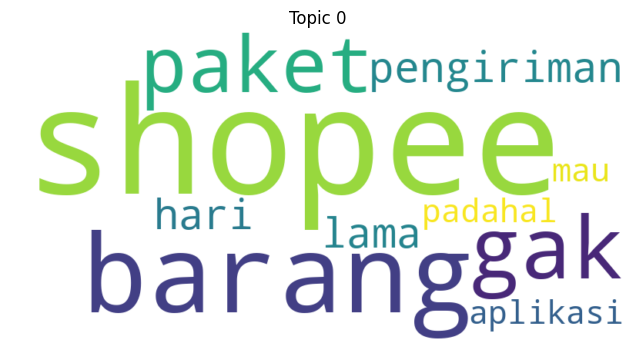

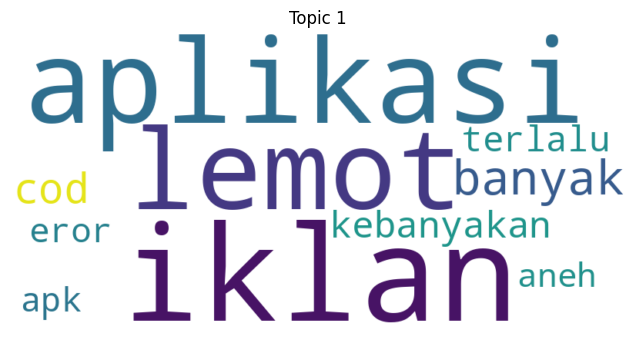

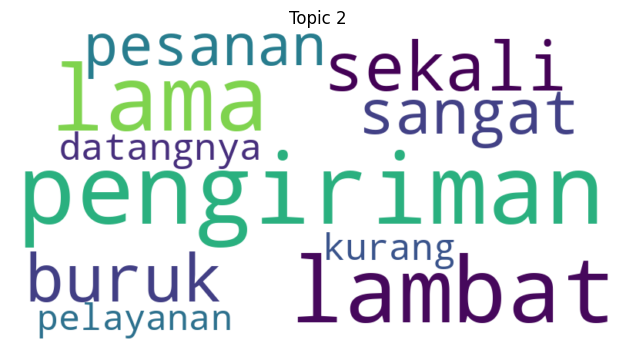

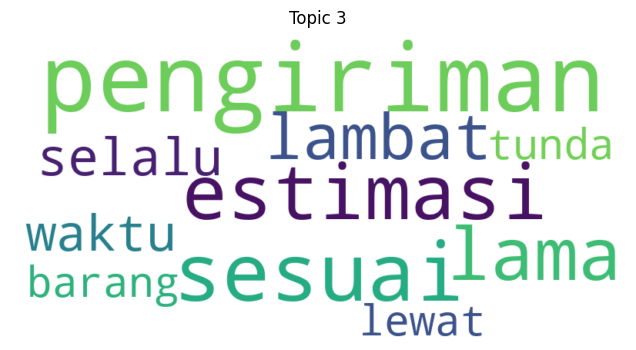

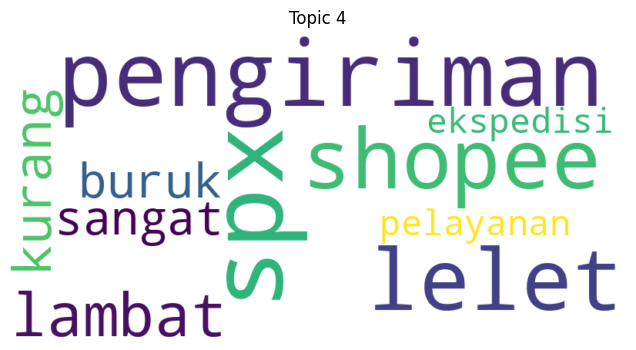


--- Topic 0 (Representative Reviews) ---
1. shopee sangat lambat pengiriman aku tunggu sampe hari lama gak suka

2. shopee semakin kesini makin kacau estimasi waktu pengiriman cuma hari sekarang sampe minggu lebih kali perhatikan pengiriman lah shopee

3. cukup kecewa kali pesanan terakhir selalu lewat tanggal estimasi pengantaran pernah tepat waktu paket datang sekarang bahkan jemput centernya gak mau ngasih alasan besok antarkan aplikasi shopee bagus banyak berbagai fitur kurir shopee selalu buat kecewa kurir lainnya selalu aman


--- Topic 1 (Representative Reviews) ---
1. kebanyakan iklan apk

2. makin aneh banyak iklan

3. terlalu banyak iklan lama


--- Topic 2 (Representative Reviews) ---
1. pengiriman sangat lambat sekali

2. lambat pengiriman

3. pengiriman lama


--- Topic 3 (Representative Reviews) ---
1. pengiriman sesuai estimasi

2. pengiriman terlalu lambat sesuai estimasi pengiriman

3. pengiriman lama sesuai estimasi


--- Topic 4 (Representative Reviews) ---
1. pengi

(<bertopic._bertopic.BERTopic at 0x787409204ef0>,
    Topic  Count                                Name  \
 0     -1    323     -1_shopee_pengiriman_makin_lama   
 1      0   2035           0_shopee_barang_gak_paket   
 2      1    174       1_iklan_aplikasi_lemot_banyak   
 3      2     71     2_pengiriman_lama_lambat_sekali   
 4      3     60   3_pengiriman_sesuai_estimasi_lama   
 5      4     34       4_spx_pengiriman_lelet_shopee   
 6      5     22  5_paylater_modal_update_menginstal   
 7      6     16              6_jasa_kirim_buruk_spx   
 
                                       Representation  \
 0  [shopee, pengiriman, makin, lama, lambat, sema...   
 1  [shopee, barang, gak, paket, pengiriman, lama,...   
 2  [iklan, aplikasi, lemot, banyak, cod, kebanyak...   
 3  [pengiriman, lama, lambat, sekali, buruk, sang...   
 4  [pengiriman, sesuai, estimasi, lama, lambat, s...   
 5  [spx, pengiriman, lelet, shopee, lambat, kuran...   
 6  [paylater, modal, update, menginstal, pay

In [65]:
analyze_app_version(data, version="3.61.28")



========== Analisis Versi 3.61.28 ==========



   Topic  Count                                    Name  \
1      0    256                    0_gak_kurir_lama_mau   
2      1    202      1_sesuai_pesanan_barang_pengiriman   
3      2    180  2_membantu_memudahkan_kebutuhan_sangat   
4      3    106            3_ongkir_gratis_banyak_murah   
5      4     97           4_shopee_selalu_barang_banyak   

                                                                                    Representation  \
1                                    [gak, kurir, lama, mau, aku, barang, apa, kalau, paket, beli]   
2              [sesuai, pesanan, barang, pengiriman, barangnya, harga, cepat, waktu, bagus, tepat]   
3  [membantu, memudahkan, kebutuhan, sangat, rumah, online, berbelanja, keluar, mencari, aplikasi]   
4               [ongkir, gratis, banyak, murah, promo, ongkirnya, harga, discount, lebih, voucher]   
5               [shopee, selalu, barang, banyak, harga, terbaik, lengkap, cepat, sangat, aplikasi]   

                                

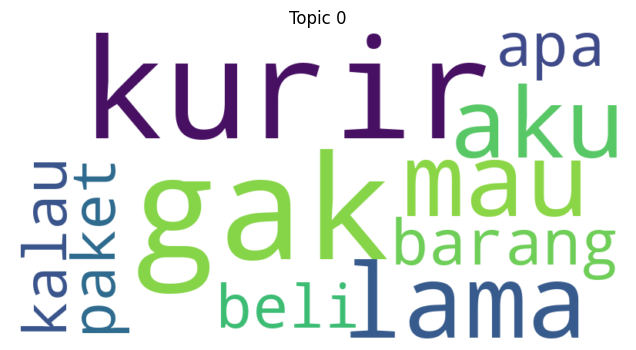

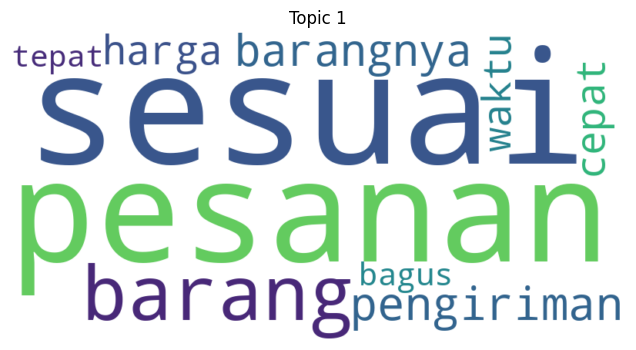

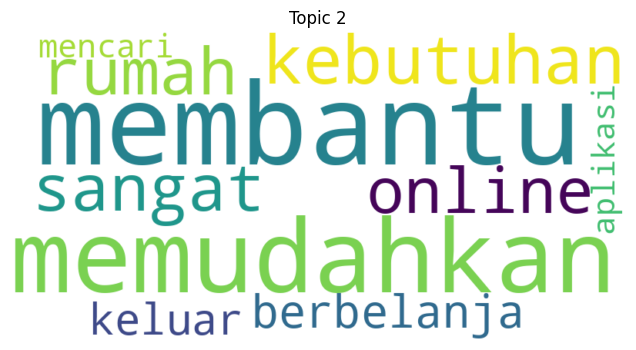

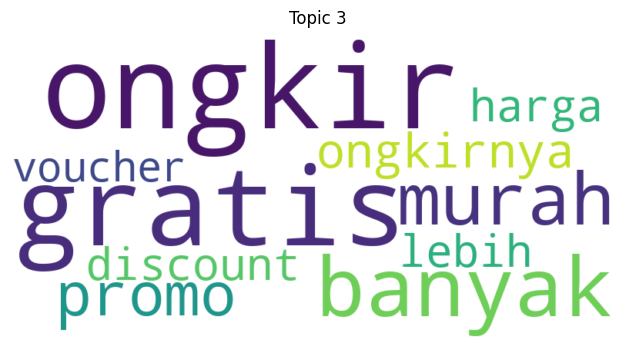

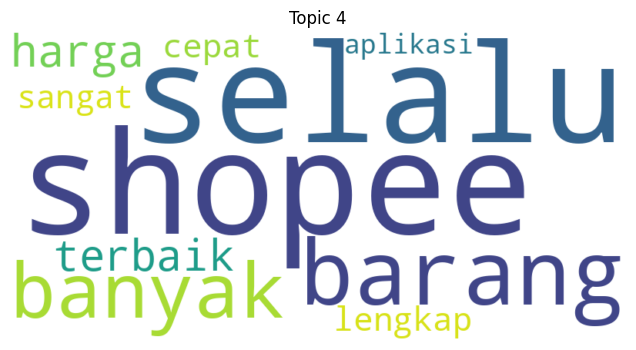


--- Topic 0 (Representative Reviews) ---
1. hai shopee minta amanah apa gambar video sama pesan pelanggan karna sering cod barang gak sesuai pesan terima sekian terimakasih saran terimakasih

2. kadang barang toko amanah baik toko amanah terutama beli buah buruk semua gak bagus selama beli sesuai dgn perkiraan toko bersifat kurang baik tujuannya menipu lebih baik blokir sama shopee merugikan pelanggan mhn maaf terimakasih shopee krn tempat berbelanja mudah jarang belanja luar krn kesibukan waktu unt kurir toko amanah harga sesuai dgn tertera

3. harga aman pelayanan ramah lama kelamaan beli shopee kurir lama gak satset terlalu lama lewat tanggal estimasi mau pergi malah gak jadi gara gara shopee kurang cepet buat bertengkar orang


--- Topic 1 (Representative Reviews) ---
1. barang sesuai pesanan harga murah

2. barang murah sesuai pesanan

3. barang sesuai pesanan pelayanan bagus pengiriman cepat


--- Topic 2 (Representative Reviews) ---
1. aplikasi sangat membantu belanja online

2

(<bertopic._bertopic.BERTopic at 0x7f7b22d42360>,
     Topic  Count                                     Name  \
 0      -1   1111        -1_shopee_belanja_sangat_aplikasi   
 1       0    256                     0_gak_kurir_lama_mau   
 2       1    202       1_sesuai_pesanan_barang_pengiriman   
 3       2    180   2_membantu_memudahkan_kebutuhan_sangat   
 4       3    106             3_ongkir_gratis_banyak_murah   
 5       4     97            4_shopee_selalu_barang_banyak   
 6       5     88              5_memang_shopee_mantap_love   
 7       6     83             6_puas_belanja_disini_senang   
 8       7     78               7_lebih_mudah_belanja_jadi   
 9       8     76             8_semoga_sukses_semakin_maju   
 10      9     71                   9_jos_mantul_shpee_jis   
 11     10     67           10_mudah_belanja_shopee_adanya   
 12     11     55             11_mudah_cepat_praktis_hemat   
 13     12     44          12_mantap_mantapp_mantab_mantep   
 14     13     44   

In [ ]:
analyze_app_version(data, version="3.61.28", sentimen='positive')


## 3.60.30 Version

In [ ]:
# 1. Version 3.60.30 shows a very focused issue: slow delivery.

# Almost all complaints fall into two major categories:
# Extremely slow delivery
# SPX courier problems (often not contacting customers, items never arriving)

# This version is more single-issue compared to version 3.59.41
# (which had topics like intrusive ads, bugs, etc.).

# Facts:
# ~90% of negative reviews come from logistics issues, not UI/UX or bugs.

# 2. Complaints about ads still appear but are not dominant

# From the representative documents of Topic 0, there are a few cases like:
# “Shopee ads keep popping up”
# But these are minor compared to delivery issues.

# 3. The convergence into only two major clusters indicates:
# User complaints are highly similar → clusters do not split into many groups
# Slow delivery is likely a major and consistent issue in this version
# This causes BERTopic to treat most texts as belonging to the same theme
# Other versions (3.59.41 / 3.61.28) produce more topics → meaning their complaints are more diverse.



========== Analisis Versi 3.60.30 ==========

   Topic  Count                            Name  \
0      0   1115        0_shopee_barang_lama_gak   
1      1    164  1_pengiriman_lama_banyak_iklan   

                                      Representation  \
0  [shopee, barang, lama, gak, aplikasi, padahal,...   
1  [pengiriman, lama, banyak, iklan, lemot, terla...   

                                 Representative_Docs  
0  [shopee makin gak jelas tiba akun gak selalu t...  
1  [pengiriman lama, pengiriman terlalu lama, pen...  


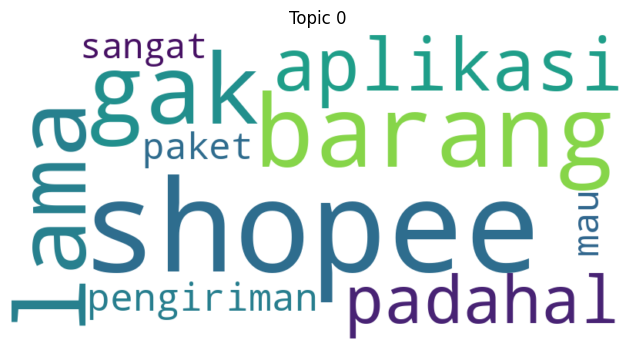

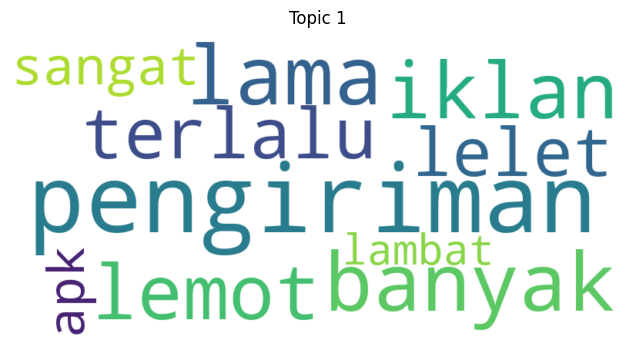


--- Topic 0 (Representative Reviews) ---
1. shopee makin gak jelas tiba akun gak selalu terbatalkan shopee dibilang aktifitas gak wajar padahal cuma punya satu akun hadeuh mohon diperbaiki segera sistem shopee karna banyak begini bukan cuma lapor berbelit gak solusi

2. aplikasi memang bagus kurir nyebelin seminggu lalu persen barang sampek sekarang datang barang katanya dikirim sekarang barangnya mohon shopee kasih lebih cepet pengiriman barang jangan sponsor iklan shopee ngapa capek liatnya pengen buka apk banyak bet shopee gua punya shopee ngapain muncul terus iklan shopee lah jangan gitu capek liatnya geram liat iklannya

3. sekarang shopee enak kayak dulu sejak jnt keluar shopee kurir spx barangnya sampe telpon kirim telpon dulu mau hubungi antrian lama dulu mau balikin akun udh pake perlukan akunku lama tetep balik lah mending pindah aplikasi sering kecewakan shopee dulu beli barang pernah tipu penjual


--- Topic 1 (Representative Reviews) ---
1. pengiriman lama

2. pengiriman 

(<bertopic._bertopic.BERTopic at 0x7874094cedb0>,
    Topic  Count                            Name  \
 0      0   1115        0_shopee_barang_lama_gak   
 1      1    164  1_pengiriman_lama_banyak_iklan   
 
                                       Representation  \
 0  [shopee, barang, lama, gak, aplikasi, padahal,...   
 1  [pengiriman, lama, banyak, iklan, lemot, terla...   
 
                                  Representative_Docs  
 0  [shopee makin gak jelas tiba akun gak selalu t...  
 1  [pengiriman lama, pengiriman terlalu lama, pen...  ,
    Topic  Count                            Name  \
 0      0   1115        0_shopee_barang_lama_gak   
 1      1    164  1_pengiriman_lama_banyak_iklan   
 
                                       Representation  \
 0  [shopee, barang, lama, gak, aplikasi, padahal,...   
 1  [pengiriman, lama, banyak, iklan, lemot, terla...   
 
                                  Representative_Docs  
 0  [shopee makin gak jelas tiba akun gak selalu t...  
 1  [pe

In [66]:
analyze_app_version(data, version="3.60.30")


## Trend Analysis

In [ ]:


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


In [ ]:
# Searching optimal k value for our Kmeans in train_global_topics() (BELOW THIS ELBOW & SILHOUETTE CELL)

In [ ]:
warnings.filterwarnings("ignore")


def find_optimal_k(data, sentiment="negative", k_min=2, k_max=10):
    print("Finding Optimal K (Elbow + Silhouette)")

    # Filter negative review
    df_neg = data[data["sentiment_pred"] == sentiment].copy()
    df_neg["clean"] = df_neg["review_text"].apply(clean_text)

    texts = df_neg["clean"].tolist()

    # Embedding IndoBERT
    embedding_model = SentenceTransformer("indobenchmark/indobert-base-p1")
    embeddings = embedding_model.encode(texts, show_progress_bar=True)

    inertias = []
    silhouettes = []

    K_range = range(k_min, k_max + 1)

    for k in K_range:
        print(f"Training KMeans with k={k} ...")

        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(embeddings)

        inertia = kmeans.inertia_
        inertias.append(inertia)

        # Silhouette only valid if >1 cluster and <n_samples
        if len(set(labels)) > 1:
            sil = silhouette_score(embeddings, labels)
        else:
            sil = -1

        silhouettes.append(sil)


    # Plot Elbow
    plt.figure(figsize=(12, 5))
    plt.plot(K_range, inertias, marker='o')
    plt.xticks(K_range)
    plt.title("Elbow Method (Inertia vs K)")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()


    # Plot Silhouette
    plt.figure(figsize=(12, 5))
    plt.plot(K_range, silhouettes, marker='o')
    plt.xticks(K_range)
    plt.title("Silhouette Score vs K")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()


    print("Summary")
    for k, inertia, sil in zip(K_range, inertias, silhouettes):
        print(f"k={k} | inertia={inertia:.2f} | silhouette={sil:.4f}")

    # Recommend K: silhouette max
    optimal_k = K_range[np.argmax(silhouettes)]
    print(f">>> RECOMMENDED K (based on silhouette): {optimal_k}")

    return optimal_k, inertias, silhouettes


Finding Optimal K (Elbow + Silhouette)


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Training KMeans with k=2 ...
Training KMeans with k=3 ...
Training KMeans with k=4 ...
Training KMeans with k=5 ...


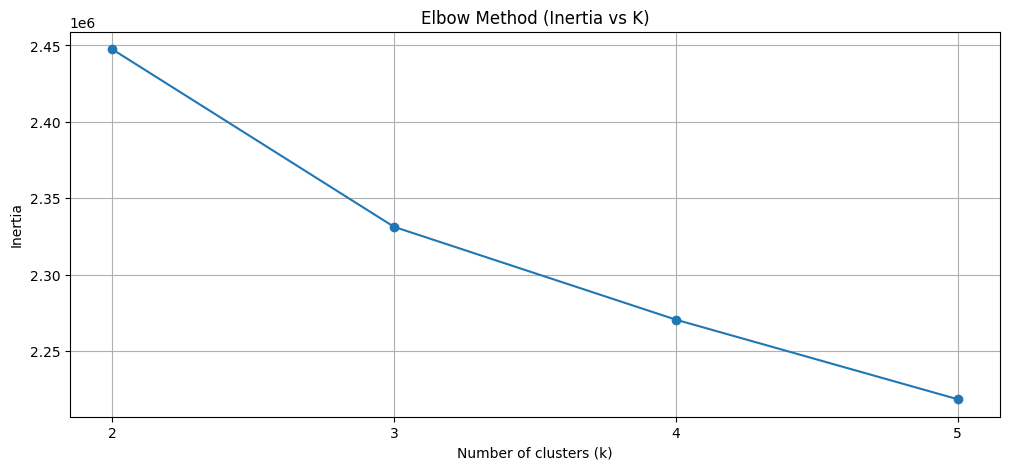

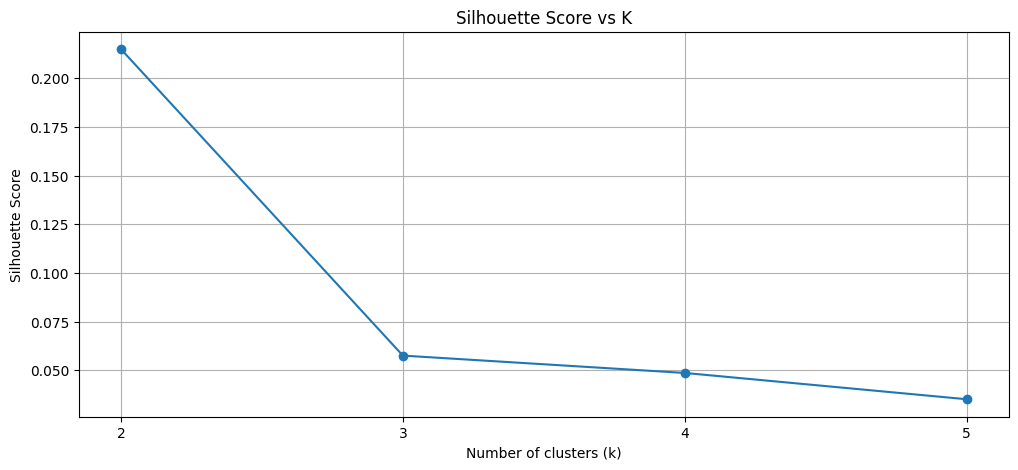

Summary
k=2 | inertia=2447537.25 | silhouette=0.2149
k=3 | inertia=2331377.75 | silhouette=0.0575
k=4 | inertia=2270659.25 | silhouette=0.0486
k=5 | inertia=2218602.75 | silhouette=0.0351
>>> RECOMMENDED K (based on silhouette): 2


In [ ]:
optimal_k, inertias, silhouettes = find_optimal_k(data, k_min=2, k_max=5)


In [ ]:
# global topic clustering on all reviews predicted as a specific sentiment (default: negative). It uses IndoBERT sentence embeddings and KMeans to identify high-level topic groups across the entire dataset.

# Workflow:
# Filter by sentiment
# Selects only reviews where sentiment_pred matches the target (e.g., "negative").

# Text cleaning
# Applies the custom clean_text() function to normalize and preprocess each review.

# Embedding generation
# Uses the pretrained IndoBERT (indobert-base-p1) model to convert each cleaned review into a dense vector representation.

# KMeans clustering
# Performs KMeans clustering on the IndoBERT embeddings to discover global topics.
# n_topics controls how many clusters/topics to create.
# random_state=42 ensures reproducibility.

# Assign topic labels
# Adds a new column global_topic to the filtered dataframe, containing the cluster index for each review.

# Return results
# The dataframe of negative reviews with assigned global topics
# The trained KMeans model for later use

# Returns
# df_neg: DataFrame containing only the selected sentiment reviews, with an added global_topic column.
# kmeans: The trained KMeans clustering model.

In [ ]:

# GLOBAL TOPIC TRAINING (all  negative review)
def train_global_topics(data, sentiment="negative", n_topics=3):
    df_neg = data[data["sentiment_pred"] == sentiment]

    df_neg["clean"] = df_neg["review_text"].apply(clean_text)

    texts = df_neg["clean"].tolist()

    # Embedding IndoBERT
    embedding_model = SentenceTransformer("indobenchmark/indobert-base-p1")
    embeddings = embedding_model.encode(texts, show_progress_bar=True)

    # KMeans global clustering
    kmeans = KMeans(n_clusters=n_topics, random_state=42)
    labels = kmeans.fit_predict(embeddings)

    df_neg["global_topic"] = labels

    return df_neg, kmeans



In [ ]:
# generates topic representations by extracting the top TF-IDF keywords for each global topic previously assigned by KMeans.

# Workflow

# Iterate through all topics
# For each topic index 0 .. n_topics-1, select all reviews belonging to that topic.

# TF-IDF Vectorization
# Convert the cleaned texts into TF-IDF vectors using TfidfVectorizer

# max_features=3000 keeps the vocabulary manageable.

# Compute average TF-IDF score
# For each topic cluster, calculate the mean TF-IDF weight across all documents.

# Extract top keywords
# Identify the top_n terms with the highest average TF-IDF score.
# These words serve as the topic's representative keywords.

# Return keyword dictionary
# Returns a dictionary where:

# Key = topic number
# Value = list of top-n keywords describing that topic

# Returns

# topic_keywords:
# A dictionary mapping each topic index to its top TF-IDF keywords.

In [ ]:
# TOPIC REPRESENTATION (TOP WORDS PER TOPIC)
def get_topic_keywords(df_neg, n_topics=3, top_n=15):
    topic_keywords = {}

    for topic in range(n_topics):
        docs = df_neg[df_neg["global_topic"] == topic]["clean"].tolist()
        if len(docs) == 0:
            continue

        vectorizer = TfidfVectorizer(max_features=3000)
        tfidf = vectorizer.fit_transform(docs)
        tfidf_means = tfidf.mean(axis=0).A1
        vocab = vectorizer.get_feature_names_out()

        top_idx = tfidf_means.argsort()[::-1][:top_n]
        keywords = [vocab[i] for i in top_idx]

        topic_keywords[topic] = keywords

    return topic_keywords




In [ ]:
# calculates how frequently each global topic appears in every app version, allowing you to analyze trending issues across versions.

# Workflow

# Iterate through each app version
# For each version in the provided list, select only reviews that match that version.

# Count topic occurrences
# For each version, compute how many reviews belong to each global topic using Counter.

# Store results
# For every topic index 0 .. n_topics-1, store:
# version number
# topic ID
# count of reviews assigned to that topic

# Convert to DataFrame
# Returns a tidy DataFrame for easy plotting (line chart, heatmap, etc.).

# Returns
# A DataFrame with columns:
# version
# topic
# count
# This structure is suitable for trend analysis, time-series visualization, or tracking dominant complaint categories across app updates.

In [ ]:
# TREND PER VERSION (GLOBAL TOPIC)
def compute_topic_trend(df_neg, versions, n_topics=3):
    trend = []

    for v in versions:
        df_v = df_neg[df_neg["review_app_version"] == v]

        if df_v.empty:
            continue

        counts = Counter(df_v["global_topic"])

        for t in range(n_topics):
            trend.append({
                "version": v,
                "topic": t,
                "count": counts.get(t, 0)
            })

    return pd.DataFrame(trend)


In [ ]:
# plot_trend(df_trend)

# Draws a line chart showing how topic counts change across app versions.
# X-axis = version, Y-axis = number of reviews in that topic.
# Each topic is shown as a separate colored line.

# run_full_pipeline(data, versions, n_topics=3)
# Runs the entire workflow:
# Train topic model → gets negative reviews + assigned cluster (df_neg, kmeans).
# Extract top keywords for each topic.
# Compute topic trend across versions.
# Plot the trend using plot_trend.

# Returns:

# df_neg : negative reviews with topic labels
# topic_keywords : top words per topic
# df_trend : topic trend table

In [ ]:

def plot_trend(df_trend):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_trend, x="version", y="count", hue="topic", marker="o")
    plt.xticks(rotation=90)
    plt.title("Trend Global Topics per Version")
    plt.tight_layout()
    plt.show()


def run_full_pipeline(data, versions, n_topics=3):
    df_neg, kmeans = train_global_topics(data, n_topics=n_topics)

    topic_keywords = get_topic_keywords(df_neg, n_topics=n_topics)
    print("\n=== GLOBAL TOPIC KEYWORDS ===")
    for t, words in topic_keywords.items():
        print(f"Topic {t}: {', '.join(words[:10])}")

    df_trend = compute_topic_trend(df_neg, versions, n_topics=n_topics)
    print("\n=== TOPIC TREND ===")
    print(df_trend)

    plot_trend(df_trend)

    return df_neg, topic_keywords, df_trend

In [ ]:
# Topic 0 – Delivery Issues: Complaints about slow shipping, SPX couriers, and delayed packages.
# Topic 1 – App Performance: Most dominant topic; users report the app being slow, not opening, and too many ads/videos.
# Topic 2 – Mixed Minor Issues: Smaller cluster involving lag, ads, and some COD-related complaints.

# Trend Insights
# Topic 1 consistently has the highest complaint volume, showing app performance is the main user pain point.
# Topic 0 spikes sharply in versions 3.59–3.61, indicating major delivery/logistics problems during these releases.
# Topic 2 remains the smallest, suggesting these issues are less critical.


# App performance issues dominate overall feedback, while delivery problems surge heavily in specific versions.
# The period around versions 3.59–3.61 shows the highest negative complaint volume across all topics.

Batches:   0%|          | 0/469 [00:00<?, ?it/s]


=== GLOBAL TOPIC KEYWORDS ===
Topic 0: pengiriman, shopee, barang, lama, paket, kurir, hari, sekarang, gak, spx
Topic 1: shopee, aplikasi, gak, buka, mau, video, makin, iklan, padahal, langsung
Topic 2: pengiriman, lama, aplikasi, lemot, iklan, lambat, cod, sangat, banyak, shopee

=== TOPIC TREND ===
     version  topic  count
0    3.40.11      0     53
1    3.40.11      1     74
2    3.40.11      2     22
3    3.41.45      0     43
4    3.41.45      1    136
5    3.41.45      2     29
6    3.42.24      0     81
7    3.42.24      1    128
8    3.42.24      2     31
9    3.43.40      0    147
10   3.43.40      1    210
11   3.43.40      2     59
12   3.44.26      0    141
13   3.44.26      1    179
14   3.44.26      2     36
15   3.45.60      0    179
16   3.45.60      1    239
17   3.45.60      2     54
18   3.46.37      0    140
19   3.46.37      1    142
20   3.46.37      2     36
21   3.47.39      0    100
22   3.47.39      1     91
23   3.47.39      2     29
24   3.47.40      0   

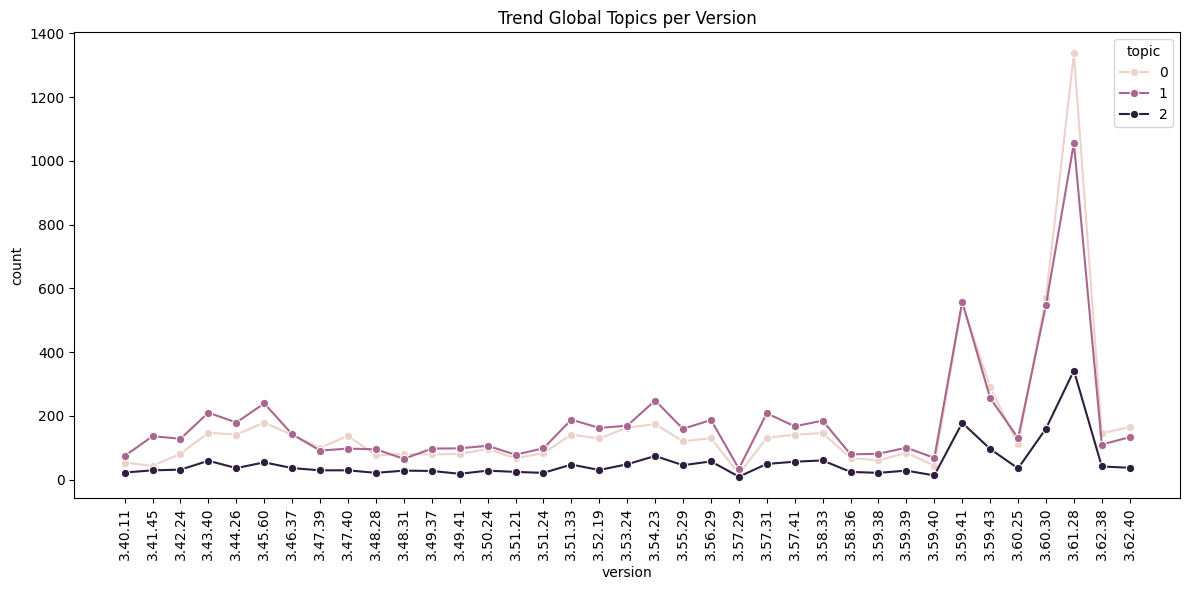

In [ ]:
versions = [
    "3.40.11",
    "3.41.45",
    "3.42.24",
    "3.43.40",
    "3.44.26",
    "3.45.60",
    "3.46.37",
    "3.47.39",
    "3.47.40",
    "3.48.28",
    "3.48.31",
    "3.49.37",
    "3.49.41",
    "3.50.24",
    "3.51.21",
    "3.51.24",
    "3.51.33",
    "3.52.19",
    "3.53.24",
    "3.54.23",
    "3.55.29",
    "3.56.29",
    "3.57.29",
    "3.57.31",
    "3.57.41",
    "3.58.33",
    "3.58.36",
    "3.59.38",
    "3.59.39",
    "3.59.40",
    "3.59.41",
    "3.59.43",
    "3.60.25",
    "3.60.30",
    "3.61.28",
    "3.62.38",
    "3.62.40"
]
df_neg, topic_keywords, df_trend = run_full_pipeline(data, versions)


In [ ]:
# Conclusion

In [ ]:
# Three Negative Themes Are Stable and Clearly Separated

# Based on the top keywords:

# Topic 0 — Shipping Delays (SPX / slow delivery)
# Dominant terms: pengiriman, lama, barang, paket, kurir, spx
# This cluster captures complaints specifically related to delivery delays and SPX courier issues.

# Topic 1 — App Issues / UX / Ads / Unable to Open the App
# Dominant terms: aplikasi, buka, video, iklan, makin, langsung, gak
# Represents user frustration with the application: intrusive ads, app not opening, heavy UI, video autoplay, etc.

# Topic 2 — Technical Performance (slow / laggy app)
# Dominant terms: lama, lemot, iklan, lambat, sangat
# Focuses more on performance issues (slowness, lag), not UX features.

# Interpretation
# T0 = Logistics problems
# T1 = UX / Feature issues
# T2 = Technical performance issues

# The model successfully distinguishes between “delivery problems” and “app performance problems,” which is meaningful from a product/business standpoint.



In [ ]:
# 2. Topic 1 (App/UX Issues) Shows Strong Upward Trend

# Across versions:
# Early versions (3.40–3.43) already show a sharp rise in Topic 1 complaints.
# After version 3.43, Topic 1 becomes the most frequent complaint.
# In high-volume version ranges (3.54–3.62), Topic 1 consistently dominates.

# Implication:
# The most persistent and largest pain point is app-related issues: app freezing, not opening, lag, intrusive ads.
# This is the primary product concern, more severe than shipping.

# 3. Topic 0 (Shipping Issues) Stays Large but Fluctuates

# Observations:
# Topic 0 remains high in absolute numbers.
# But it fluctuates — no consistent upward trend.
# Does not correlate strongly with specific app versions.

# Interpretation:
# Shipping issues are operational, not driven by app updates.
# They are steady, recurring, but not tied to technical releases.

# 4. Topic 2 (Technical Performance) Is Small but Persistent

# Never dominates.
# Always appears across all versions.
# Peaks slightly in high-traffic versions (3.59–3.61).

# Interpretation:
# Technical performance issues are a persistent low-level problem.
# They likely relate to device compatibility, caching behavior, or network architecture — long-term optimization topics.

# 5. Major Spikes at Versions 3.59.41 and 3.60.30–3.61.28

# All three topics rise sharply at the same time.
# This suggests:

# A massive increase in total reviews (not topic-specific).
# Possibly a major app update, large-scale UI change, or system-wide instability.
# Could also reflect a surge in active users.
# Since no topic spikes independently, the issue is systemic rather than isolated.

# 6. Topic Stability Over Time
# Keyword consistency shows:

# Topic 0 = shipping
# Topic 1 = UX/features
# Topic 2 = performance

# There is no semantic drift.
# This confirms that k = 3 is a stable and meaningful clustering, and the model did not collapse or merge unrelated themes.

## Topic Drift Analysis

In [ ]:
df_trend.head()

version  topic  count
0  3.40.11      0     53
1  3.40.11      1     74
2  3.40.11      2     22
3  3.41.45      0     43
4  3.41.45      1    136

In [ ]:
df_neg, kmeans = train_global_topics(data, n_topics=3)
data["global_topic"] = df_neg["global_topic"]


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
# NaN appears because the global_topic column is only filled for reviews that are included in the subset used when training KMeans, namely reviews with sentiment_pred=="negative".

In [ ]:
data.head(10)

Unnamed: 0                                        review_text  rating  \
0           0                                              lelet       3   
1           1  sayang sedang tidak suka dengan shopee, sangat...       1   
2           2                                       sangat bagus       5   
3           3                                                . .       4   
4           4       barang ada yang tidak sesuai yang diklankan😭       2   
5           5  susah banget login diakun kita sendiri dari bu...       2   
6           6  gatau kenapa skrg shopee bener bener jelek jas...       1   
7           7                 banyak bgt iklan lu, ganggu banget       1   
8           8                      shoppe nikin mudah berbelanja       5   
9           9  sfood lagi parah sy nunggu 1 jam lebih buat dp...       2   

   likes review_app_version          review_date latest_version  \
0      0            3.43.40  2025-03-15 22:27:15        3.62.40   
1      0            3.60.30  2025-10-27 23:50:30        3.62.40   
2      0            3.61.28  2025-11-24 03:50:44        3.62.40   
3      0            3.59.41  2025-10-13 06:10:27        3.62.40   
4      0            3.56.29  2025-09-22 02:48:38        3.62.40   
5      0            3.61.28  2025-11-19 07:51:25        3.62.40   
6      0            3.60.30  2025-11-25 08:23:10        3.62.40   
7      0            3.61.28  2025-11-25 14:47:45        3.62.40   
8      0            3.59.43  2025-11-21 15:18:28        3.62.40   
9      0            3.40.11  2025-04-06 13:51:48        3.62.40   

  latest_version_release_date  text_len sentiment sentiment_pred  global_topic  
0                  2025-11-28         5   neutral       negative           2.0  
1                  2025-11-28       184  negative       negative           0.0  
2                  2025-11-28        12  positive       positive           NaN  
3                  2025-11-28         3  positive       positive           NaN  
4                  2025-11-28        44  negative        neutral           NaN  
5                  2025-11-28       119  negative       negative           1.0  
6                  2025-11-28       315  negative       negative           0.0  
7                  2025-11-28        34  negative       negative           1.0  
8                  2025-11-28        29  positive       positive           NaN  
9                  2025-11-28        75  negative       negative           1.0

In [ ]:
data.shape

(30213, 12)

In [ ]:
# Purpose for this code:
# Measure how topic proportions change across app versions (topic drift).

# Steps:

# Prepare data:
# Filter negative reviews and compute topic proportions per version.

# Visualize topic trend:
# Plot topic proportions over versions to see shifts.

# Measure drift:
# Compute Jensen–Shannon divergence between consecutive versions.

# Output interpretation:
# Show versions with the largest drift (biggest change in topic composition).

In [ ]:
# The versions with the highest JS divergence show the largest shift in negative-review topics compared to the previous version.
# 1. Biggest Topic Shifts

# The top 3 versions with the strongest drift are:
# v3.41.45 — JS 0.124
# → The largest change in topic proportions. Likely a major shift in user complaints (e.g., spike in ads, shipping issues, or performance issues).

# v3.42.24 — JS 0.105
# → Another strong shift, possibly responding to or worsening the same emerging issues.

# v3.48.28 — JS 0.094
# → Significant change, meaning the dominant complaint types changed again.



In [ ]:
# 2. What this means

# These versions introduced changes that altered what users complained about the most.
# A higher JS divergence indicates:
# New problems emerged, or
# Previous issues were reduced but replaced by different issues.

# 3. Notable mid/lower drift versions

# v3.59.41 — JS 0.079
# This version shows a noticeable shift as well, but not as extreme as the top ones.

# Versions like 3.54.23, 3.57.41, 3.60.25 show mild-to-moderate drift, meaning topics changed but not dramatically.

# 4. Summary (Very Short)
# Major topic changes happened at v3.41.45 and v3.42.24.
# Moderate changes at v3.48.x and v3.59.41.
# Other versions show normal fluctuation.

<Figure size 1200x600 with 0 Axes>

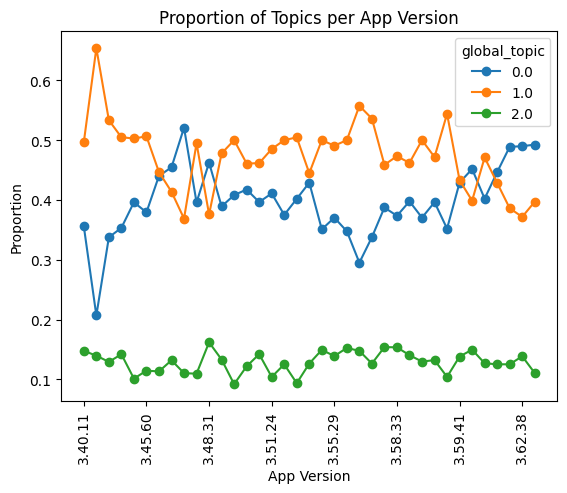

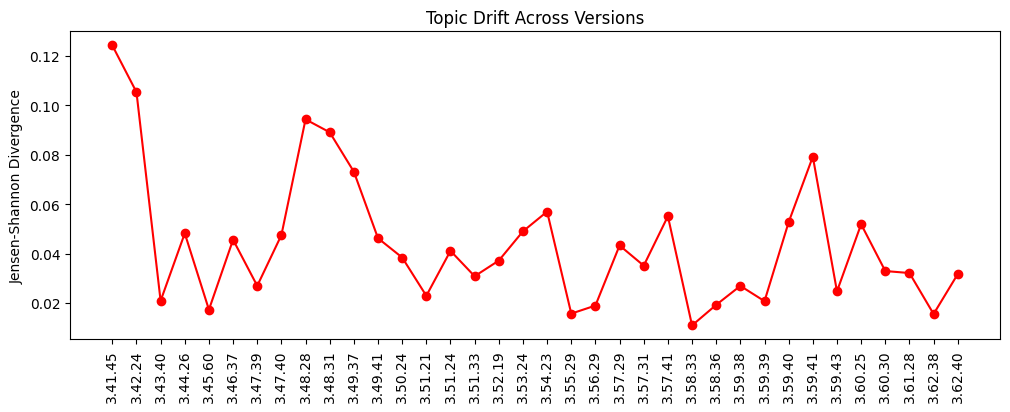

    version  js_divergence
0   3.41.45       0.124215
1   3.42.24       0.105330
8   3.48.28       0.094291
9   3.48.31       0.089060
29  3.59.41       0.079195
10  3.49.37       0.073113
18  3.54.23       0.056965
23  3.57.41       0.055092
28  3.59.40       0.052711
31  3.60.25       0.051856


In [ ]:

# Keep only negative reviews with assigned global topics
df_drift = data[data["sentiment_pred"] == "negative"].dropna(subset=["global_topic"]).copy()

topic_dist = df_drift.groupby(["review_app_version", "global_topic"]).size().unstack(fill_value=0)

topic_prop = topic_dist.div(topic_dist.sum(axis=1), axis=0)


# Visualize topic proportion drift
plt.figure(figsize=(12, 6))
topic_prop.plot(kind="line", marker="o")
plt.title("Proportion of Topics per App Version")
plt.xlabel("App Version")
plt.ylabel("Proportion")
plt.xticks(rotation=90)
plt.show()

# Quantitative drift metric (Jensen–Shannon)
versions = topic_prop.index.tolist()
js_scores = []

for i in range(len(versions)-1):
    p = topic_prop.iloc[i].values
    q = topic_prop.iloc[i+1].values
    js = jensenshannon(p, q)
    js_scores.append(js)

plt.figure(figsize=(12, 4))
plt.plot(versions[1:], js_scores, marker="o", color="red")
plt.xticks(rotation=90)
plt.ylabel("Jensen-Shannon Divergence")
plt.title("Topic Drift Across Versions")
plt.show()

df_js = pd.DataFrame({
    "version": versions[1:],
    "js_divergence": js_scores
})
print(df_js.sort_values(by="js_divergence", ascending=False).head(10))


In [ ]:
data.head()

Unnamed: 0                                        review_text  rating  \
0           0                                              lelet       3   
1           1  sayang sedang tidak suka dengan shopee, sangat...       1   
2           2                                       sangat bagus       5   
3           3                                                . .       4   
4           4       barang ada yang tidak sesuai yang diklankan😭       2   

   likes review_app_version          review_date latest_version  \
0      0            3.43.40  2025-03-15 22:27:15        3.62.40   
1      0            3.60.30  2025-10-27 23:50:30        3.62.40   
2      0            3.61.28  2025-11-24 03:50:44        3.62.40   
3      0            3.59.41  2025-10-13 06:10:27        3.62.40   
4      0            3.56.29  2025-09-22 02:48:38        3.62.40   

  latest_version_release_date  text_len sentiment sentiment_pred  global_topic  
0                  2025-11-28         5   neutral       negative           2.0  
1                  2025-11-28       184  negative       negative           0.0  
2                  2025-11-28        12  positive       positive           NaN  
3                  2025-11-28         3  positive       positive           NaN  
4                  2025-11-28        44  negative        neutral           NaN

In [ ]:
df_neg.head()

Unnamed: 0                                        review_text  rating  \
0           0                                              lelet       3   
1           1  sayang sedang tidak suka dengan shopee, sangat...       1   
5           5  susah banget login diakun kita sendiri dari bu...       2   
6           6  gatau kenapa skrg shopee bener bener jelek jas...       1   
7           7                 banyak bgt iklan lu, ganggu banget       1   

   likes review_app_version          review_date latest_version  \
0      0            3.43.40  2025-03-15 22:27:15        3.62.40   
1      0            3.60.30  2025-10-27 23:50:30        3.62.40   
5      0            3.61.28  2025-11-19 07:51:25        3.62.40   
6      0            3.60.30  2025-11-25 08:23:10        3.62.40   
7      0            3.61.28  2025-11-25 14:47:45        3.62.40   

  latest_version_release_date  text_len sentiment sentiment_pred  \
0                  2025-11-28         5   neutral       negative   
1                  2025-11-28       184  negative       negative   
5                  2025-11-28       119  negative       negative   
6                  2025-11-28       315  negative       negative   
7                  2025-11-28        34  negative       negative   

   global_topic                                              clean  
0             2                                              lelet  
1             0  sayang sedang suka shopee sangat buruk karna s...  
5             1  susah login diakun sendiri bulan kmren coba lo...  
6             0  gatau skrg shopee bener bener jelek jasa pengi...  
7             1                            banyak bgt iklan ganggu

In [ ]:

# Computes how similar the top keywords of each topic are between consecutive app versions.

# How it works
# For each topic, iterate through all app versions.
# For each version–topic pair:
# Take all review texts.
# Build a TF-IDF vector (top N words only).
# Compute the average TF-IDF weight → represents the “keyword signature” of that topic in that version.

# For each consecutive version pair:
# Compute cosine similarity between keyword signatures.

# Return a dataframe containing:
# topic
# version_prev
# version_curr
# cosine_similarity

# Interpretation of Cosine Similarity
# 1.00 → identical keyword distribution
# 0.90–0.99 → highly stable topic wording
# 0.75–0.89 → moderate changes in wording
# < 0.75 → strong shift: new keywords, new complaints

In [67]:

def compute_keyword_similarity(df, versions, topic_col="global_topic", top_n=10):
    """
    Compute cosine similarity of top keywords per topic between consecutive versions.
    """
    sim_rows = []

    for topic in df[topic_col].dropna().unique():
        prev_vec = None
        prev_version = None

        for version in sorted(versions):
            # Filter reviews for this version & topic
            df_vt = df[(df["review_app_version"] == version) & (df[topic_col] == topic)]
            if df_vt.empty:
                continue

            # Combine texts for TF-IDF
            texts = df_vt["clean"].tolist()
            vectorizer = TfidfVectorizer(max_features=top_n)
            tfidf_matrix = vectorizer.fit_transform(texts)
            # Average TF-IDF per term
            tfidf_avg = tfidf_matrix.mean(axis=0).A1

            if prev_vec is not None:
                sim = cosine_similarity([prev_vec], [tfidf_avg])[0][0]
                sim_rows.append({
                    "topic": topic,
                    "version_prev": prev_version,
                    "version_curr": version,
                    "cosine_similarity": sim
                })

            prev_vec = tfidf_avg
            prev_version = version

    return pd.DataFrame(sim_rows)



In [ ]:
# Keyword similarity shows that most topics are highly stable across versions, meaning users talk about the same problem types with similar wording.
# Topic 2 has a couple of dips around versions 3.55–3.57, indicating a temporary shift in how users describe the problem. Topic 1 shows the most variation,
#suggesting it captures issues that change more frequently, while Topic 0 is extremely stable, representing a persistent complaint category that remains unchanged across all updates.

In [ ]:
# Topic 2
# Usually 0.82–0.95 range → stable.

# Lowest dips:
# 3.55.29 → 3.56.29 = 0.762
# 3.56.29 → 3.57.29 = 0.774

# These two dips indicate:
# A meaningful shift in wording, probably new complaint types or different user phrasing.

# Topic 0
# Very high stability (0.90–0.99 consistently).
# Users complain using almost the same keywords every version.

# Interpretation:
# This topic represents a persistent, unchanged problem (common cases: delivery issues, login issues, ads, stuck loading, etc.).

# Topic 1
# More variation (ranges 0.76–0.95).

# Notable dips:
# 3.40.11 → 3.41.45 = 0.76
# 3.49.41 → 3.50.24 = 0.73
# 3.52.19 → 3.53.24 = 0.78
# 3.60.30 → 3.61.28 = 0.78

# Interpretation:
# Topic 1 shows the most frequent keyword shifts.
# Likely the “dynamic” topic — new issues appear here first.

In [68]:

versions = sorted(df_neg["review_app_version"].unique())
df_keyword_sim = compute_keyword_similarity(df_neg, versions, topic_col="global_topic", top_n=15)
print(df_keyword_sim)

     topic version_prev version_curr  cosine_similarity
0        2      3.40.11      3.41.45           0.806598
1        2      3.41.45      3.42.24           0.937352
2        2      3.42.24      3.43.40           0.891855
3        2      3.43.40      3.44.26           0.895387
4        2      3.44.26      3.45.60           0.840830
5        2      3.45.60      3.46.37           0.819862
6        2      3.46.37      3.47.39           0.914505
7        2      3.47.39      3.47.40           0.925170
8        2      3.47.40      3.48.28           0.879856
9        2      3.48.28      3.48.31           0.852048
10       2      3.48.31      3.49.37           0.874605
11       2      3.49.37      3.49.41           0.843002
12       2      3.49.41      3.50.24           0.858216
13       2      3.50.24      3.51.21           0.954552
14       2      3.51.21      3.51.24           0.895626
15       2      3.51.24      3.51.33           0.804481
16       2      3.51.33      3.52.19           0

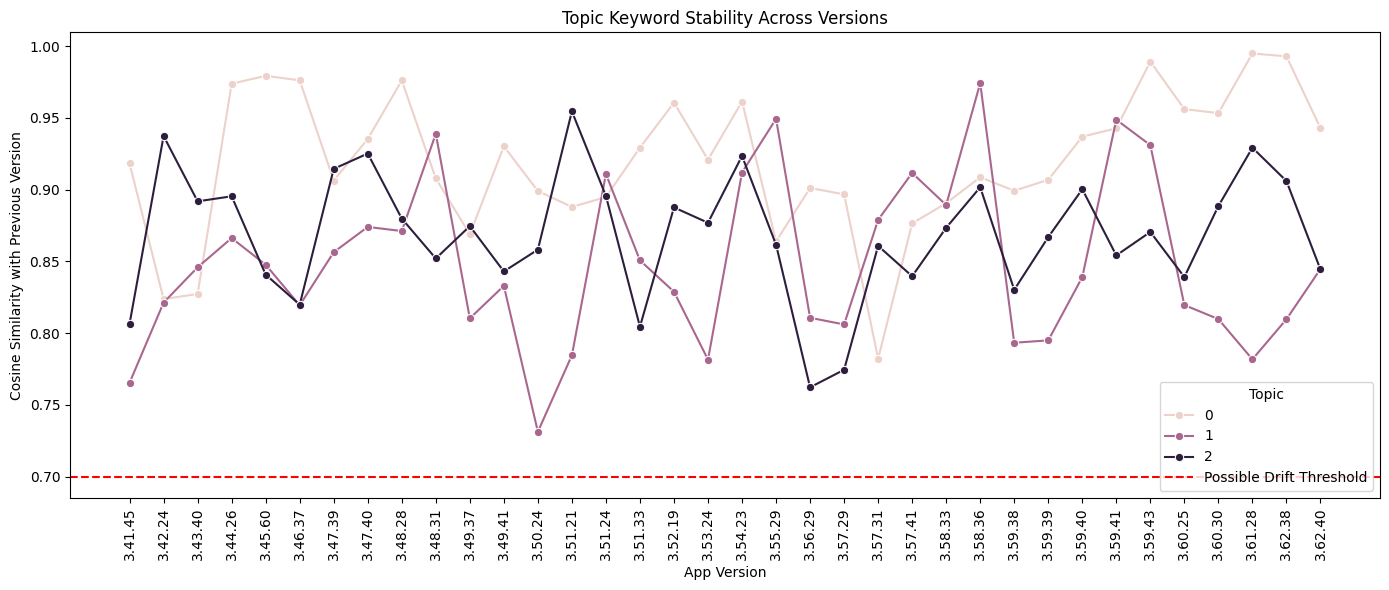

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(
    data=df_keyword_sim,
    x='version_curr',
    y='cosine_similarity',
    hue='topic',
    marker='o'
)

plt.xticks(rotation=90)
plt.xlabel('App Version')
plt.ylabel('Cosine Similarity with Previous Version')
plt.title('Topic Keyword Stability Across Versions')
plt.axhline(0.7, color='red', linestyle='--', label='Possible Drift Threshold')
plt.legend(title='Topic')
plt.tight_layout()
plt.show()
